# Аналіз глибинних поглядів
### Магістерська робота
<i>Савенко Ілля</i>


В даній роботі розглядається задача інтелектуального аналізу даних тексту а саме пошук глибинних поглядів. Робота розглядає задачу аналіз тексту з соціальної мережі Телеграм. В ході проведення дослідження було взято дані з телеграм каналу публічної людини Ігоря Лаченкова. Публічний блог має охоплення у 1 136 690 людей(станом на 21 квітня). Канал обʼєднує певну соціальну думку категорії українців. Мета дослідження - це проаналізувати текстові властивості та побудувати задачу класифікації(регресії), що дозволять побудувати модель відображення соціальної думки щодо подій, описаних на каналі. Дана робота не досліджує саму соціальну думку щодо описаних подій, а досліджує побудову звʼязку між соціальною думкою аудиторії та подією. В подальшому для відтворення та передбачення думки щодо новостворених новин.

#### Імпортування необхідних інструментальних бібілотек

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import random
import json

#### Імпорт бібліотек для позначення частин мови
Pos-tagging

In [3]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='uk')

#### Імпорт бібліотек для обробки інтелектуального аналізу тексту

In [4]:
import nltk
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from gensim.models import Word2Vec
from tensorflow.keras.utils import plot_model

import tensorflow as tf
from keras import backend as K

In [5]:
from IPython.core.display import display, HTML

#### Імпорт бібліотек для побудови моделі класифікатору та навчання

In [6]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#### Імпорт бібліотек для зняття метрик з побудованої моделі

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import det_curve

## Опис даних
Як було вже вищеописано, дані узяті з каналу публічної людини. Структура повідомлень - це пост з мережі Телеграм. В ньому пристуні такі влсативості:
- id: ідентифікатор повідомлення
- peer_id: ідентифікатор каналу
- date: дата публікації
- message: текст повідомлення
- out: чи вихідне повідомлення
- mentioned: чи вказаний автор, який робив експорт
- media_unread: чи прочитані медіаматеріали користувачем
- silent: чи було надіслано повідомлення без нотифікованого сповіщення
- post: чи є це постом каналу
- from_scheduled: чи було надіслано запланованим
- legacy: чи застаріле по актуальності повідослення(чи було змінене воно згодом)
- pinned: закурпленість на каналі
- fwd_from_channel: чи було переслано з іношого каналу
- fwd_from_message: чи було переслано з іншого персонального повідомлення
- reply_to: чи має структуру відповіді - якщо так позначає ідентифікатор повідослення на яке була відповідь
- views: кількість переглядів
- forward: кількість пересилань
- reactions: реакції на повідомлення

Для дослідження було взято останні 13 000 повідомлень оскільки переважна більшість з них написана Українською мовою. Попередні пости були написані російською мовою. 

In [8]:
df = pd.read_csv("Лачен пише.csv", sep="|")[:13000]
df = df.sample(frac=1)
df

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions
823,27797,1536630827,"03/17/2023, 14:02:53",NaN,False,False,False,False,True,False,False,False,None,None,None,656459.0,5354.0,"{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}"
9992,17669,1536630827,"08/19/2022, 22:06:25",У Харкові вибухи,False,False,False,False,True,False,False,False,None,None,None,423815.0,117.0,"{'❤': 24, '🔥': 0, '😁': 50, '😢': 1074, '🤬': 11990}"
6379,21726,1536630827,"10/28/2022, 21:02:08",В іранському дроні Mohajer-6 знайшли українськ...,False,False,False,False,True,False,False,False,None,None,None,527234.0,3814.0,"{'❤': 69, '🔥': 158, '😁': 1369, '😢': 935, '🤬': ..."
1719,26830,1536630827,"02/18/2023, 07:08:46",Щось гарненьке на світлині від голови Миколаїв...,False,False,False,False,True,False,False,False,None,None,26829,577184.0,281.0,"{'❤': 1230, '🔥': 14541, '😁': 172, '😢': 63, '🤬'..."
4,28677,1536630827,"04/25/2023, 11:58:26",Зеленський провів чергове засідання Ставки Вер...,False,False,False,False,True,False,False,False,None,None,None,443781.0,133.0,"{'❤': 2295, '🔥': 15761, '😁': 130, '😢': 59, '🤬'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3048,25396,1536630827,"01/11/2023, 14:30:34",❗️Литва надасть Україні системи протиповітряно...,False,False,False,False,True,False,False,False,None,None,25392,495442.0,2009.0,"{'❤': 40186, '🔥': 2459, '😁': 112, '😢': 0, '🤬':..."
631,28001,1536630827,"03/24/2023, 07:03:33",Гарно палає,False,False,False,True,True,False,False,False,None,None,27999,573507.0,618.0,"{'❤': 1127, '🔥': 25874, '😁': 321, '😢': 16, '🤬'..."
6747,21327,1536630827,"10/20/2022, 09:22:27",Німеччина має намір підготувати до 5 тисяч укр...,False,False,False,False,True,False,False,False,None,None,None,532443.0,421.0,"{'❤': 18928, '🔥': 623, '😁': 888, '😢': 77, '🤬':..."
3549,24850,1536630827,"12/30/2022, 22:33:18",NaN,False,False,False,False,True,False,False,False,1154166453,5519,None,439502.0,3138.0,"{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}"


In [9]:
def extract_proper_name(text):
    return re.findall(r"\b[А-ЯЄІЇ]{1,}[а-яєії]{0,}\b", text)

In [10]:
pd.isna(df.loc[[6]]["message"]).bool()

False

In [11]:
proper_names = []
for index, row in df.iterrows():
    if pd.isna(row["message"]):
        continue
    proper_names_local = extract_proper_name(row["message"])
    proper_names = proper_names + proper_names_local

In [12]:
morph.parse("гей")

[Parse(word='гей', tag=OpencorporaTag('INTJ'), normal_form='гей', score=1.0, methods_stack=((DictionaryAnalyzer(), 'гей', 1, 0),)),
 Parse(word='гей', tag=OpencorporaTag('NOUN,anim masc,nomn'), normal_form='гей', score=1.0, methods_stack=((DictionaryAnalyzer(), 'гей', 128, 0),))]

## Попередня обробка текстових повідомлень

In [13]:
processing_df = df["message"]
processing_df

823                                                   NaN
9992                                     У Харкові вибухи
6379    В іранському дроні Mohajer-6 знайшли українськ...
1719    Щось гарненьке на світлині від голови Миколаїв...
4       Зеленський провів чергове засідання Ставки Вер...
                              ...                        
3048    ❗️Литва надасть Україні системи протиповітряно...
631                                           Гарно палає
6747    Німеччина має намір підготувати до 5 тисяч укр...
3549                                                  NaN
3231    Жодних переговорів з росією про "різдвяне пере...
Name: message, Length: 13000, dtype: object

In [14]:
print(morph.parse("Азовсталь"))

[Parse(word='азовсталь', tag=OpencorporaTag('NOUN,femn,inan nomn'), normal_form='азовсталь', score=1.0, methods_stack=((DictionaryAnalyzer(), 'азовсталь', 182, 0),)), Parse(word='азовсталь', tag=OpencorporaTag('NOUN,femn,inan accs'), normal_form='азовсталь', score=1.0, methods_stack=((DictionaryAnalyzer(), 'азовсталь', 182, 3),))]


#### Стоп слова
Визначимо категорії стоп-слів. Вони є допоміжними та частіше всього не несуть велику кількість інформації
Віднесемо до цієї категорії усі службові частини мови: <i>прийменник, сполучник, частка, вигук</i>

In [15]:
stop_words_categories = ["PREP", "CONJ", "INTJ", "PRCL", "NPRO"]
def delete_stop_words(text):
    new_text = ""
    words = text.split(" ")
    for word in words:
        word_metainfo = random.choice(morph.parse(word))
        if word_metainfo.tag.POS not in stop_words_categories:
            new_text = new_text + " " + word
            
    return new_text.strip()

In [16]:
tt_stop_words = "Я на що та гору круту кремʼяную, буду камінь важкий підіймать"
delete_stop_words(tt_stop_words)

'Я гору круту кремʼяную, буду камінь важкий підіймать'

#### Приведення слів тексту до нормальної форми - стемінг
Зведення слів до нормальної форми - називний відмінок, однина

In [17]:
def norm_form(text):
    new_text = ""
    words = text.split(" ")
    for word in words:
        word_metainfo = random.choice(morph.parse(word))
        new_text = new_text + " " + word_metainfo.normal_form
            
    return new_text.strip()

In [18]:
tt_norm_form = "Несучи вагу ту страшную, буду пісню веселу співать"
norm_form(tt_norm_form)

'несучи вага той страшную, буда пісня веселий співати'

#### Видалення розділових знаків та іншої нетекстової інформації

In [19]:
def extract_text_only(text):
    words = re.findall(r"[А-ЯЄІЇа-яєії]{1,}", text)
    return " ".join([word for word in words])

In [20]:
tt_text_only = "Я у темную нічку не видну, не стулю ні на хвильку очей!"
extract_text_only(tt_text_only)

'Я у темную нічку не видну не стулю ні на хвильку очей'

In [21]:
def text_processing(text):
    text = extract_text_only(text)
    text = delete_stop_words(text)
    text = norm_form(text)
    return text

In [22]:
tt_all_preprocessing = "Гетьте думи ви хмари осінні"
text_processing(tt_all_preprocessing)

'дума хмара осінній'

## Проведемо першопочаткове перетворення тексту
Видалимо усі розділові знаки та службові частини мови, проведемо стемінг

In [23]:
df["processed_text"] = df["message"]
df["processed_text"] = df["processed_text"].apply(str).apply(text_processing)

df["processed_text_no_stemming"] = df["message"]
df["processed_text_no_stemming"] = df["processed_text_no_stemming"].apply(str).apply(extract_text_only)

In [24]:
df["processed_text"]

823                                                      
9992                                        у харко вибух
6379    в іранський дронь знайти український компонент...
1719         гарненький світлина голова миколаївський ова
4       зеленський провести черговий засідання ставок ...
                              ...                        
3048    литво надати україна система протиповітряний о...
631                                          гарно палати
6747    німеччина мати намірити підготувати до тисяча ...
3549                                                     
3231    переговори росія різдвяний перемир україна вес...
Name: processed_text, Length: 13000, dtype: object

In [25]:
df["reactions"][0]

"{'❤': 15, '🔥': 5, '😁': 31, '😢': 569, '🤬': 6503}"

### Парсинг позначок тексту
Як ми можемо звернути увагу на реакції, залишені читачами спільноти, допустимо зробити певний висновок відношення людини до тієї чи іншої новини. Опишемо припущення щодо емоціного відношення по емоджі:
- ❤: "любов" - може відображати певне тепле ставлення людини до новини, під якою вона поставила дану реакцію.
- 🔥: "вогник" - позитивне емоційне збудження до новини
- 😁: "сміх" - допис здався кумедним
- 😢: "плач" - допис має негативне забарвлення та відображає емоційне подавлення
- 🤬: "злість" - допис викликає відчуття злості та негативне збудження

Видалимо дані, де усі реакції дорівнюють 0, оскільки проведення аналізу тексту виконати неможливо. 

In [26]:
df["reactions"].value_counts()

{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}                 1142
{'❤': 23910, '🔥': 1192, '😁': 104, '😢': 43, '🤬': 43}         1
{'❤': 14001, '🔥': 166, '😁': 3553, '😢': 105, '🤬': 646}       1
{'❤': 37, '🔥': 31, '😁': 38, '😢': 1233, '🤬': 17436}          1
{'❤': 14983, '🔥': 0, '😁': 57, '😢': 2310, '🤬': 49}           1
                                                         ... 
{'❤': 28, '🔥': 0, '😁': 43, '😢': 1152, '🤬': 13117}           1
{'❤': 21131, '🔥': 1764, '😁': 104, '😢': 128, '🤬': 540}       1
{'❤': 19011, '🔥': 305, '😁': 1084, '😢': 26, '🤬': 24}         1
{'❤': 42, '🔥': 79, '😁': 54, '😢': 1074, '🤬': 16177}          1
{'❤': 39903, '🔥': 3576, '😁': 72, '😢': 57, '🤬': 85}          1
Name: reactions, Length: 11859, dtype: int64

Бачимо, що маємо 1142 дописа, що не мають реакцій. Такі дописи вилучимо з нашого датасету.

In [27]:
empty_reactions = df["reactions"].value_counts().keys()[0]
df = df[df["reactions"] != empty_reactions]
df.head()

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,processed_text_no_stemming
9992,17669,1536630827,"08/19/2022, 22:06:25",У Харкові вибухи,False,False,False,False,True,False,False,False,None,None,None,423815.0,117.0,"{'❤': 24, '🔥': 0, '😁': 50, '😢': 1074, '🤬': 11990}",у харко вибух,У Харкові вибухи
6379,21726,1536630827,"10/28/2022, 21:02:08",В іранському дроні Mohajer-6 знайшли українськ...,False,False,False,False,True,False,False,False,None,None,None,527234.0,3814.0,"{'❤': 69, '🔥': 158, '😁': 1369, '😢': 935, '🤬': ...",в іранський дронь знайти український компонент...,В іранському дроні знайшли український компоне...
1719,26830,1536630827,"02/18/2023, 07:08:46",Щось гарненьке на світлині від голови Миколаїв...,False,False,False,False,True,False,False,False,None,None,26829,577184.0,281.0,"{'❤': 1230, '🔥': 14541, '😁': 172, '😢': 63, '🤬'...",гарненький світлина голова миколаївський ова,Щось гарненьке на світлині від голови Миколаїв...
4,28677,1536630827,"04/25/2023, 11:58:26",Зеленський провів чергове засідання Ставки Вер...,False,False,False,False,True,False,False,False,None,None,None,443781.0,133.0,"{'❤': 2295, '🔥': 15761, '😁': 130, '😢': 59, '🤬'...",зеленський провести черговий засідання ставок ...,Зеленський провів чергове засідання Ставки Вер...
4384,23903,1536630827,"12/12/2022, 09:52:07",Уряд Нової Зеландії запровадив санкції проти 2...,False,False,False,False,True,False,False,False,None,None,None,452853.0,82.0,"{'❤': 15623, '🔥': 1574, '😁': 127, '😢': 15, '🤬'...",уряд новий зеландія запровадити санкція проти ...,Уряд Нової Зеландії запровадив санкції проти р...


* Зведему кожний елемент в колонці реакцій в формат словника.
* Перетворимо дані позначки у нумеровані категорії для усіх текстових даних.

In [28]:
def convert_to_dict(text):
    json_acceptable_string = text.replace("'", "\"")
    json_dict = json.loads(json_acceptable_string)
    return dict(json_dict)

In [29]:
df["reactions"] = df["reactions"].apply(convert_to_dict)
df.head(3)

/tmp/ipykernel_16382/2484381893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reactions"] = df["reactions"].apply(convert_to_dict)


,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,processed_text_no_stemming
9992,17669,1536630827,"08/19/2022, 22:06:25",У Харкові вибухи,False,False,False,False,True,False,False,False,None,None,None,423815.0,117.0,"{'❤': 24, '🔥': 0, '😁': 50, '😢': 1074, '🤬': 11990}",у харко вибух,У Харкові вибухи
6379,21726,1536630827,"10/28/2022, 21:02:08",В іранському дроні Mohajer-6 знайшли українськ...,False,False,False,False,True,False,False,False,None,None,None,527234.0,3814.0,"{'❤': 69, '🔥': 158, '😁': 1369, '😢': 935, '🤬': ...",в іранський дронь знайти український компонент...,В іранському дроні знайшли український компоне...
1719,26830,1536630827,"02/18/2023, 07:08:46",Щось гарненьке на світлині від голови Миколаїв...,False,False,False,False,True,False,False,False,None,None,26829,577184.0,281.0,"{'❤': 1230, '🔥': 14541, '😁': 172, '😢': 63, '🤬'...",гарненький світлина голова миколаївський ова,Щось гарненьке на світлині від голови Миколаїв...


#### Знаходження емоджі з максимальною кількістю поставлених реакцій

In [30]:
def max_grab(emoji_dict):
    return max(emoji_dict, key=emoji_dict.get)

Оберемо випадкову реакцію та знайдемо реакцію з максимальним відгуком

In [31]:
random_attitude = random.choice(df["reactions"])
random_attitude

{'❤': 1744, '🔥': 25231, '😁': 318, '😢': 17, '🤬': 27}

In [32]:
max_grab(random_attitude)

'🔥'

In [33]:
df["max_reaction"] = df["reactions"].apply(max_grab)
df.head(4)

/tmp/ipykernel_16382/3717174282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["max_reaction"] = df["reactions"].apply(max_grab)


,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,processed_text_no_stemming,max_reaction
9992,17669,1536630827,"08/19/2022, 22:06:25",У Харкові вибухи,False,False,False,False,True,False,...,False,None,None,None,423815.0,117.0,"{'❤': 24, '🔥': 0, '😁': 50, '😢': 1074, '🤬': 11990}",у харко вибух,У Харкові вибухи,🤬
6379,21726,1536630827,"10/28/2022, 21:02:08",В іранському дроні Mohajer-6 знайшли українськ...,False,False,False,False,True,False,...,False,None,None,None,527234.0,3814.0,"{'❤': 69, '🔥': 158, '😁': 1369, '😢': 935, '🤬': ...",в іранський дронь знайти український компонент...,В іранському дроні знайшли український компоне...,🤬
1719,26830,1536630827,"02/18/2023, 07:08:46",Щось гарненьке на світлині від голови Миколаїв...,False,False,False,False,True,False,...,False,None,None,26829,577184.0,281.0,"{'❤': 1230, '🔥': 14541, '😁': 172, '😢': 63, '🤬'...",гарненький світлина голова миколаївський ова,Щось гарненьке на світлині від голови Миколаїв...,🔥
4,28677,1536630827,"04/25/2023, 11:58:26",Зеленський провів чергове засідання Ставки Вер...,False,False,False,False,True,False,...,False,None,None,None,443781.0,133.0,"{'❤': 2295, '🔥': 15761, '😁': 130, '😢': 59, '🤬'...",зеленський провести черговий засідання ставок ...,Зеленський провів чергове засідання Ставки Вер...,🔥


In [34]:
df["max_reaction"].value_counts()

❤    7014
🤬    2635
🔥    1017
😁     720
😢     456
🤡      14
🍾       2
Name: max_reaction, dtype: int64

Можемо побачити, що в даних присутні аномалії. В даному випадку це реакція "клоун" та "привітання". Оскільки таких даних маємо у кількості 16, їх врахування в моделі буде обмежено. 

In [35]:
value_count_dict = dict(df["max_reaction"].value_counts())
value_count_dict

{'❤': 7014, '🤬': 2635, '🔥': 1017, '😁': 720, '😢': 456, '🤡': 14, '🍾': 2}

In [36]:
filtered_reactions_by_count = {}
MIN_COUNT = 400
for key, value in value_count_dict.items():
    if int(value) > MIN_COUNT:
        filtered_reactions_by_count[key] = value

Маємо усі реакції

In [37]:
allowed_reactions = list(filtered_reactions_by_count.keys())
allowed_reactions

['❤', '🤬', '🔥', '😁', '😢']

Фільтруємо дані

In [38]:
df = df[df["max_reaction"].isin(allowed_reactions)]

#### Категорізація

In [39]:
reaction_sample = df["reactions"][0]
reactions = list(reaction_sample.keys())
def categorize_emoji(reaction):
    emoji_index = reactions.index(reaction)
    return emoji_index

In [40]:
print(reactions)
print(categorize_emoji("🔥"))

['❤', '🔥', '😁', '😢', '🤬']
1


#### Сумісна категоризація
Обʼєднаємо категорії ❤ та 🔥 через їхню схожість та в подальшому окремо проаналізуємо результат


<i style="color: red;">Попередження: тільки для задачі аналітики кокретного каналу</i>

In [41]:
reactions_merged_common = [[reactions[0], reactions[1]], [reactions[2]], [reactions[3]], [reactions[4]]]
reactions_merged_common

[['❤', '🔥'], ['😁'], ['😢'], ['🤬']]

In [42]:
def categorize_group_emoji(emoji):
    for i, emoji_group in enumerate(reactions_merged_common):
        if emoji in emoji_group:
            return i

In [43]:
categorize_group_emoji('🔥')

0

In [44]:
df["max_reactions_category"] = df["max_reaction"].apply(categorize_emoji)
df["max_reactions_category_generalized"] = df["max_reaction"].apply(categorize_group_emoji)
df.head(4)

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,fwd_from_message,reply_to,views,forwards,reactions,processed_text,processed_text_no_stemming,max_reaction,max_reactions_category,max_reactions_category_generalized
9992,17669,1536630827,"08/19/2022, 22:06:25",У Харкові вибухи,False,False,False,False,True,False,...,None,None,423815.0,117.0,"{'❤': 24, '🔥': 0, '😁': 50, '😢': 1074, '🤬': 11990}",у харко вибух,У Харкові вибухи,🤬,4,3
6379,21726,1536630827,"10/28/2022, 21:02:08",В іранському дроні Mohajer-6 знайшли українськ...,False,False,False,False,True,False,...,None,None,527234.0,3814.0,"{'❤': 69, '🔥': 158, '😁': 1369, '😢': 935, '🤬': ...",в іранський дронь знайти український компонент...,В іранському дроні знайшли український компоне...,🤬,4,3
1719,26830,1536630827,"02/18/2023, 07:08:46",Щось гарненьке на світлині від голови Миколаїв...,False,False,False,False,True,False,...,None,26829,577184.0,281.0,"{'❤': 1230, '🔥': 14541, '😁': 172, '😢': 63, '🤬'...",гарненький світлина голова миколаївський ова,Щось гарненьке на світлині від голови Миколаїв...,🔥,1,0
4,28677,1536630827,"04/25/2023, 11:58:26",Зеленський провів чергове засідання Ставки Вер...,False,False,False,False,True,False,...,None,None,443781.0,133.0,"{'❤': 2295, '🔥': 15761, '😁': 130, '😢': 59, '🤬'...",зеленський провести черговий засідання ставок ...,Зеленський провів чергове засідання Ставки Вер...,🔥,1,0


## Первинний аналіз тексту

In [45]:
df["words"] = df["processed_text"]
df["words"] = df["words"].apply(lambda text: text.split(" "))
df["words_len"] = df["words"].apply(lambda words: len(words))

In [46]:
df["words_len"].mean()

13.948910656983617

Середня довжина повідомлення - 14 слів у реченні.

### Duplicating categories

In [47]:
def show_category_sizes():
    print("0 category size: ", df[df["max_reactions_category_generalized"] == 0].shape)
    print("1 category size: ", df[df["max_reactions_category_generalized"] == 1].shape)
    print("2 category size: ", df[df["max_reactions_category_generalized"] == 2].shape)
    print("3 category size: ", df[df["max_reactions_category_generalized"] == 3].shape)

In [48]:
show_category_sizes()

0 category size:  (8031, 25)
1 category size:  (720, 25)
2 category size:  (456, 25)
3 category size:  (2635, 25)


In [49]:
# df = df.append([df[df["max_reactions_category_generalized"] == 1]] * 4, ignore_index=True)
# df = df.append([df[df["max_reactions_category_generalized"] == 2]] * 5, ignore_index=True)
# df = df.append([df[df["max_reactions_category_generalized"] == 3]] * 2, ignore_index=True)

In [50]:
show_category_sizes()

0 category size:  (8031, 25)
1 category size:  (720, 25)
2 category size:  (456, 25)
3 category size:  (2635, 25)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


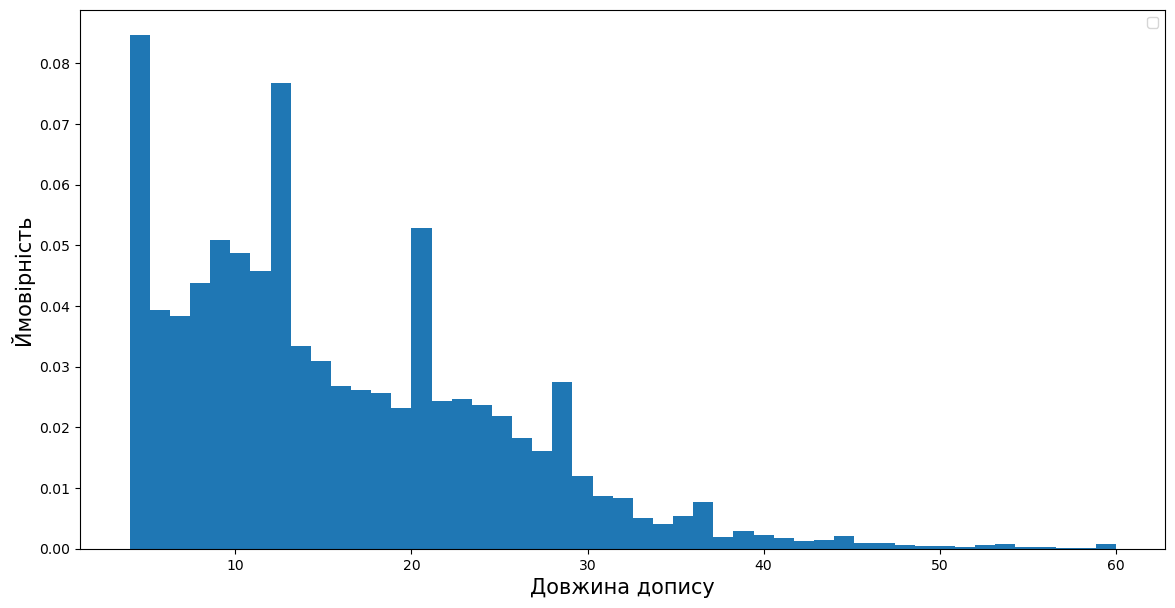

In [51]:
values = df["words_len"].values
bins = np.linspace(4, 60, 50)

fig = plt.figure(figsize = (14,7))
plt.hist(values, bins, density=True)
plt.xlabel("Довжина допису", fontsize=15)
plt.ylabel("Ймовірність", fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [52]:
df["words"] = df["processed_text"].apply(lambda text: text.split(" "))

In [53]:
sns.set()
plt.rcParams['figure.figsize'] = [15, 20]

In [54]:
def draw_word_cloud():
    wordcloud = WordCloud(background_color="white", contour_width=0.1, scale=1,
                      contour_color="black",  max_font_size=150, random_state=42,
                      colormap="Dark2")
    for i, label_name in zip(range(10), np.unique(df['max_reactions_category'])):
        df_part = df[df['max_reactions_category'] == label_name]
        words = df_part['words']
        allwords = []
        for wordlist in words:
            allwords += wordlist

        mostcommon = FreqDist(allwords).most_common(100)

        wordcloud.generate(text=str(mostcommon))   
        plt.subplot(5, 2, i+1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(label_name, fontsize=15)
    plt.show()

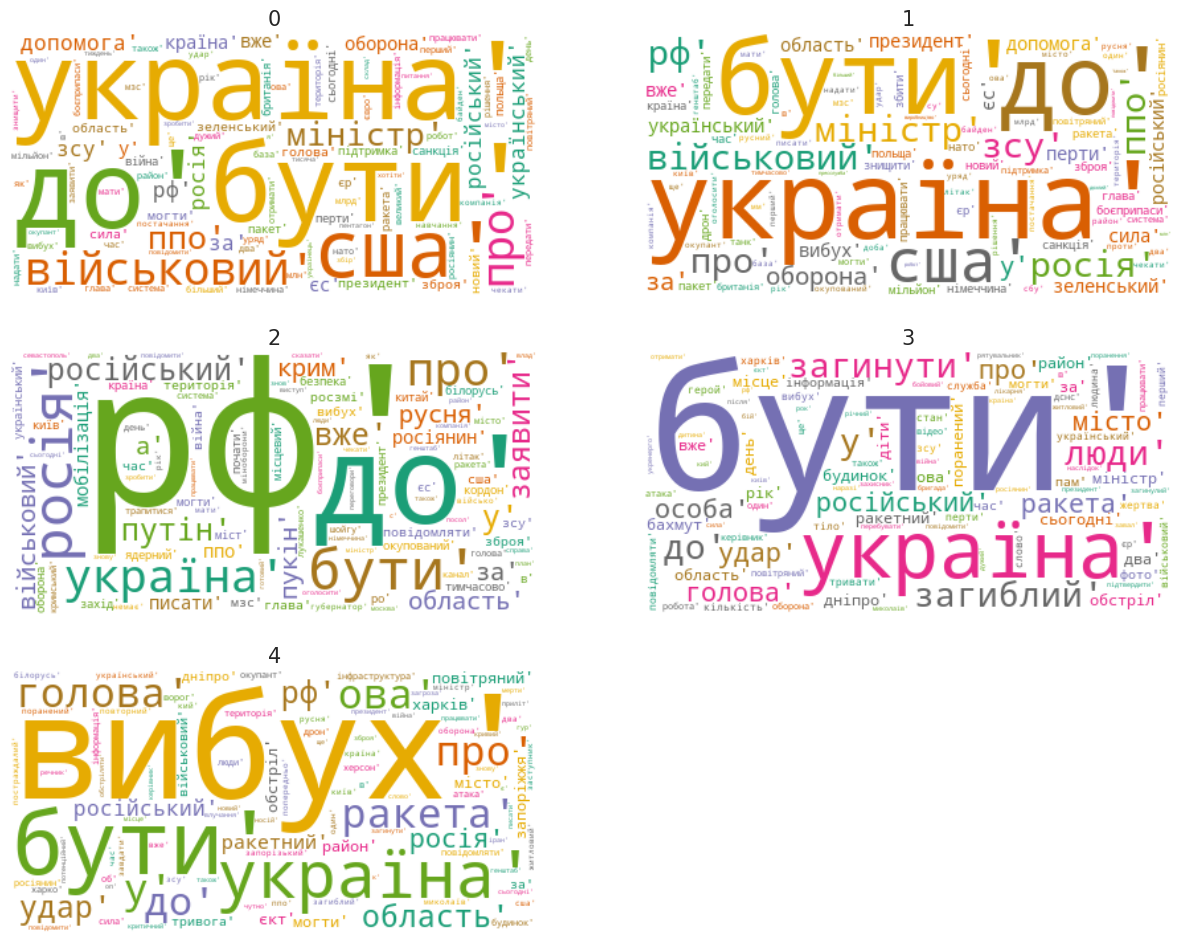

In [55]:
draw_word_cloud()

<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax">ID</th>
    <th class="tg-0lax"><span style="font-weight:400;font-style:normal">Reaction</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax"><span style="font-weight:400;font-style:normal">❤</span></th>
  </tr>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">🔥</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">2</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">😁</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">3</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">😢</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">4</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">🤬</span></td>
  </tr>
</tbody>
</table>

In [56]:
words_to_drop = ["до", "бути", "україна", "що", "про", "у", "в", "п", "сша", "військовий", "міністр", "рф"]
# words_to_drop = []
def drop_words_by_hands(words):
    for word_to_drop in words_to_drop:
        if word_to_drop in words:
            words.remove(word_to_drop)
    return words

In [57]:
df["words"] = df["words"].apply(drop_words_by_hands)

In [58]:
df["words"]

9992                                       [харко, вибух]
6379    [іранський, дронь, знайти, український, компон...
1719    [гарненький, світлина, голова, миколаївський, ...
4       [зеленський, провести, черговий, засідання, ст...
4384    [уряд, новий, зеландія, запровадити, санкція, ...
                              ...                        
2941     [вибух, одеса, можливий, повторний, робота, ппо]
3048    [литво, надати, система, протиповітряний, обор...
631                                       [гарно, палати]
6747    [німеччина, мати, намірити, підготувати, тисяч...
3231    [переговори, росія, різдвяний, перемир, вести,...
Name: words, Length: 11842, dtype: object

## Проектування ознак
На початку аналізу тексту, налаштуємо механізм вилучення ознак за методом n-gram

In [59]:
test_tokenization_message = "Гетьте думи ви хмари осінні"
words = nltk.word_tokenize(test_tokenization_message)

In [60]:
bigrams = nltk.ngrams(df["words"][2], n=2)

In [61]:
bigram_fdist = nltk.FreqDist(bigrams)

In [62]:
bigram_fdist.most_common(5)

[(('український', 'відбити'), 1),
 (('відбити', 'атака'), 1),
 (('атака', 'за'), 1),
 (('за', 'доба'), 1),
 (('доба', 'бахмутське'), 1)]

## Розділ вибірки на тренувальну, валідаційну та тестову
Розділ відбувається за такими правилами: 
* 20% - тестова вибірка
* 20% - валідаційна вибірка
* 60% - тренувальна вибірка

In [63]:
df_train, df_test = train_test_split(df, test_size=0.2, train_size=0.8)
df_train, df_val = train_test_split(df_train, test_size=0.25, train_size=0.75)

for tensorflow

In [64]:
df_train, df_test = train_test_split(df, test_size=0.2, train_size=0.8)

In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9473 entries, 7705 to 2787
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  9473 non-null   int64  
 1   peer_id                             9473 non-null   int64  
 2   date                                9473 non-null   object 
 3   message                             9451 non-null   object 
 4   out                                 9473 non-null   bool   
 5   mentioned                           9473 non-null   bool   
 6   media_unread                        9473 non-null   bool   
 7   silent                              9473 non-null   bool   
 8   post                                9473 non-null   bool   
 9   from_scheduled                      9473 non-null   object 
 10  legacy                              9473 non-null   bool   
 11  pinned                              9473

In [66]:
df_train.head(2)

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,views,forwards,reactions,processed_text,processed_text_no_stemming,max_reaction,max_reactions_category,max_reactions_category_generalized,words,words_len
7705,20276,1536630827,"10/06/2022, 17:30:01",З 15:00 по 20:00 українські військові знищили ...,False,False,False,False,True,False,...,493172.0,170.0,"{'❤': 16178, '🔥': 1616, '😁': 79, '😢': 24, '🤬':...",з український військовий знищити п ять російсь...,З по українські військові знищили п ять російс...,❤,0,0,"[з, український, знищити, ять, російський, без...",18
6657,21427,1536630827,"10/22/2022, 10:04:51","Шебекіно, Бєлгородська область.Вже другий день...",False,False,False,False,True,False,...,494783.0,460.0,"{'❤': 1029, '🔥': 17067, '😁': 628, '😢': 73, '🤬'...",шебекіно бєлгородський область вже другий день...,Шебекіно Бєлгородська область Вже другий день ...,🔥,1,0,"[шебекіно, бєлгородський, область, вже, другий...",8


In [67]:
NUMBER_OF_CATEGORIES = 4

In [68]:
def from_category(categories):
    y_all = []
    for category in categories:
        y_cell = np.zeros((NUMBER_OF_CATEGORIES, ), dtype=int)
        y_cell[category] = 1
        y_all.append(y_cell)
    y_all = np.array(y_all)
    return y_all

In [69]:
# y_train = from_category(df_train["max_reactions_category"])
# y_test = from_category(df_test["max_reactions_category"])

In [70]:
y_train = from_category(df_train["max_reactions_category_generalized"])
y_test = from_category(df_test["max_reactions_category_generalized"])

# Перетворення тексту в нумерований формат
Для подальшого формування вхідного вектору моделі, дані будуть перетворені у нумерований формат.

## Bag-of-Words
Побудуємо словникову ознаку на основі N слів, що найчастіше зустрічаються.

In [71]:
word_counts = {}
def build_word_counts(words):
    for word in words:
        if word not in list(word_counts.keys()):
            word_counts[word] = 1
        word_counts[word] += 1

In [72]:
_ = df_train["words"].aggregate(build_word_counts)

Проведемо ранжування слів за частотою їх появ

In [73]:
words_by_freq = sorted(word_counts, key=word_counts.get, reverse=True)

words_to_index = {key: rank for rank, key in enumerate(words_by_freq, 0)}
index_to_words = {index: word for word, index in words_to_index.items()}

In [74]:
print("Розмір словника: ", len(words_by_freq), "\n", end="")
print("Топ-10", words_by_freq[:10])

Розмір словника:  13094 
Топ-10 ['вибух', 'росія', 'російський', 'україна', 'ппо', 'за', 'український', 'зсу', 'голова', 'ракета']


### Побудова BOW
Для кожного допису створимо нульовий вектор з розмірністю N і заповнимо його відповідними словами, що зустрілися в цьому дописі

In [75]:
dict_size = len(words_by_freq)
def message_bow_vec(words, words_to_index):
    result_vec = np.zeros(dict_size)
    for word in words:
        if word in words_to_index:
            result_vec[words_to_index[word]] += 1
    return result_vec

In [76]:
X_train_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_train["words"]])
X_val_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_val["words"]])
print("Train X shape -> ", X_train_bow.shape, "\nValidation X shape -> ", X_val_bow.shape)

Train X shape ->  (9473, 13094) 
Validation X shape ->  (2369, 13094)


In [77]:
X_train_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_train["words"]])
X_test_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_test["words"]])

### TF-IDF
<i>Term frequency-inverse document frequency</i>

Ознака, мета якої відобразити наскільки важливе слово в документі в колекції корпусів тексту.
Цей метод є доповненням до Bag-of-Words, де частота слова поділена на загальну кількість слів. 

In [78]:
def tfidf_features_validation(X_train, X_val, X_test, n_gram_range=(1,4), n_gram_level="word"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text"].to_numpy())
    X_val_tfidf = tfidf_vectorizer.transform(X_val["processed_text"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text"].to_numpy())
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [79]:
def tfidf_features(X_train, X_test, n_gram_range=(1,4), n_gram_level="word"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text"].to_numpy())
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [80]:
def tfidf_features_unprocessed_text(X_train, X_test, n_gram_range=(3,8), n_gram_level="char"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text_no_stemming"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text_no_stemming"].to_numpy())
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [81]:
# def tfidf_features_binary(X_train, X_test, n_gram_size):
#     binary_vectorizer = 

### N-gram
Врахуємо n-gram модель представлення частин тексту для подальшого інтелектуального аналізу тексту.
* рівень слів та словосполучень
* рівень символів кирилиці 

#### Рівень слів та словосполучень
Оберемо плаваючий розмір вікна 4(врахування усіх вікон від 1(рівень слова) до 4(словосполучення))
Застосуємо цей метод з припущенням, що в текстах дописів будуть присутні слова та словосполучення, що матимуть певну 

In [82]:
X_train_tfidf_w, X_val_tfidf_w, X_test_tfid_w, tfidf_vocab_w = tfidf_features_validation(df_train, df_val, df_test)

for tf

In [83]:
X_train_tfidf_w, X_test_tfidf_w, tfidf_vocab_w = tfidf_features(df_train, df_test)

In [84]:
tfidf_reversed_vocab_w = {i: word for word, i in tfidf_vocab_w.items()}

#### Тільки словосполучення

In [85]:
X_train_tfidf_wg, X_test_tfidf_wg, tfidf_vocab_wg = tfidf_features(
    df_train, df_test, (2,3), "word")

#### Символьний рівень
Оберемо вікно від 3(корінь слова) до 10

In [86]:
X_train_tfidf_c, X_test_tfidf_c, tfidf_vocab_c = tfidf_features(
    df_train, df_test, (3,10), "char")

In [87]:
X_train_tfidf_c, X_test_tfidf_c, tfidf_vocab_c = tfidf_features(
    df_train, df_test, (3,5), "char")

In [88]:
tfidf_reversed_vocab_c = {i: char_seq for char_seq, i in tfidf_vocab_c.items()}
len(tfidf_reversed_vocab_c)

46825

In [89]:
X_train_tfidf_rc, X_test_tfidf_rc, _ = tfidf_features(df_train, df_test, (3,8), "char")

### Word2Vec

In [90]:
w2v = Word2Vec(df_train["words"], vector_size=1000, window=3)
w2v.wv.index_to_key[:10]

['вибух',
 'росія',
 'російський',
 'україна',
 'ппо',
 'за',
 'український',
 'зсу',
 'голова',
 'ракета']

Переглянемо слова що більше за інші зустрічаються в контексті зі словом "росія" 

In [91]:
w2v.wv.most_similar("росія")

[('зброя', 0.999805212020874),
 ('війна', 0.9997643232345581),
 ('рік', 0.9996275901794434),
 ('надання', 0.9996253848075867),
 ('запровадити', 0.9995771646499634),
 ('рішення', 0.9995597004890442),
 ('танк', 0.9995560050010681),
 ('сша', 0.9995250701904297),
 ('фінансовий', 0.9995236992835999),
 ('ухвалити', 0.999521791934967)]

In [92]:
w2v_words = set(w2v.wv.index_to_key)
X_train_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words]) 
                        for corpus in df_train["words"]])
X_test_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words]) 
                       for corpus in df_test["words"]])

/tmp/ipykernel_16382/3204335971.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words])
/tmp/ipykernel_16382/3204335971.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words])


In [93]:
df_train["words"]

7705     [з, український, знищити, ять, російський, без...
6657     [шебекіно, бєлгородський, область, вже, другий...
6882           [мерти, бровар, писати, робота, ппо, місто]
10949    [шановний, земляк, обстановка, неспокійний, за...
9839       [шольц, трюда, домовитися, подальший, допомога]
                               ...                        
1149     [черговий, обмін, полонений, вдатися, повернут...
5563     [удар, єкт, критичний, інфраструктура, місто, ...
2372                                       [вибух, херсон]
2772     [бачити, росіянин, вбити, мирний, житель, дніп...
2787                                   [відправити, пекти]
Name: words, Length: 9473, dtype: object

In [94]:
def show_shape(X):    
    for i, v in enumerate(X):
        if i < 10:
            print(len(df_train["words"].iloc[i]), len(v))

In [95]:
X_train_w2v_avg = []
for word_vec in X_train_w2v:
    if word_vec.size:
        X_train_w2v_avg.append(word_vec.max(axis=0))
    else:
        X_train_w2v_avg.append(np.zeros(1000, dtype=float))
        
X_test_w2v_avg = []
for word_vec in X_test_w2v:
    if word_vec.size:
        X_test_w2v_avg.append(word_vec.mean(axis=0))
    else:
        X_test_w2v_avg.append(np.zeros(1000, dtype=float))

# Мульти-класова класифікація
Для побудови вирішення задачі класифікації буде використана сигмоїдна функція. Стратегія складається у побудові одного класифікатора для одного класу. Для кожного класифікатора клас порівнюється з усіма іншими класами.

In [96]:
def plot_learning_metrics(result, title, epochs=15):
    accuracy_percentage = np.round(100 * result.history["accuracy"][-1], 3) 
    print(f"TRAIN Accuracy: {accuracy_percentage}% \n")
    
    x_range = range(epochs)
    
    fig, (loss_plt, accuracy_plt) = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
    
    loss_plt.plot(x_range, result.history["loss"], "r", label="TRAIN loss")
    loss_plt.plot(x_range, result.history["val_loss"], "g", label="TEST loss")
    loss_plt.legend()
    
    accuracy_plt.plot(x_range, result.history["accuracy"], "b", label="TRAIN accuracy")
    accuracy_plt.plot(x_range, result.history["val_accuracy"], "lightgreen", label="TEST accuracy")
    accuracy_plt.legend()
    
    plt.suptitle(f"TRAIN and TEST metrics -> {title}")
    
    fig.tight_layout()
    plt.show()

In [97]:
def false_negative(confusion_matrix, category_index):
    return np.sum(np.delete(confusion_matrix[category_index, :], category_index))

In [98]:
def false_positive(confusion_matrix, category_index):
    return np.sum(np.delete(confusion_matrix[:, category_index], category_index))

In [99]:
def true_negative(confusion_matrix, category_index):
    middle_step = np.delete(confusion_matrix, category_index, 0)
    middle_step = np.delete(middle_step, category_index, 1)
    return np.sum(middle_step)

In [100]:
def count_frr_far(confusion_matrix):
    metrics = {}
    category_count = confusion_matrix.shape[0]
    for category in range(category_count):
        tp = confusion_matrix[category][category]
        tn = true_negative(confusion_matrix, category)
        
        fn = false_negative(confusion_matrix, category)
        fp = false_positive(confusion_matrix, category)
        
        frr_value = fn / (fn + tp)
        far_value = fp / (fp + tn)
        
        metrics[category] = {"frr": frr_value, "far": far_value}
    return metrics

In [101]:
def show_confusion_matrix(y_true, y_pred):
    categories = list(range(np.max(y_true)))
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
#     cm_display.plot()
#     plt.figure().set_figheight(10).set_figwidth(10)
#     plt.show()
    
    return confusion_matrix

In [102]:
def model_and_report(model_foo, model_fit_result, X_test, y_test, model_name="", verbose=False):
    y_pred = model_foo.predict(X_test)
    _, accuracy = model_foo.evaluate(X_test, y_test, verbose=verbose)
    
    print(f"MODEL: {model_name}")
    print(f"On TEST accuracy: {accuracy}")
    plot_learning_metrics(model_fit_result, model_name)
    confusion_matrix = np.array(
        show_confusion_matrix(y_test.argmax(axis=1), np.argmax(y_pred, axis=1)))
    print("\n\nCONFUSION MATRIX: ")
    print(confusion_matrix)
    
    print("\n\nREPORT: ")
    print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(y_pred, axis=1)))

    print("\n FRR and FAR: ")
    print(json.dumps(count_frr_far(confusion_matrix), indent=2))

In [103]:
def get_metrics_table(method_name, accuracy, f1_score, precision, recall, far, frr):
    metrics_table_html = f"""
        <table>
            <thead>
                <tr>
                    <td>Method name</td>
                    <td>Accuracy</td>
                    <td>F-Score</td>
                    <td>Precision</td>
                    <td>Recall</td>
                    <td>FAR</td>
                    <td>FRR</td>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td><strong>{method_name}</strong></td>
                    <td>{accuracy}</td>
                    <td>{f1_score}</td>
                    <td>{precision}</td>
                    <td>{recall}</td>
                    <td>{far}</td>
                    <td>{frr}</td>
                </tr>
            </tbody>
        </table>
    """
    return metrics_table_html

In [104]:
display(HTML(get_metrics_table("BOW", 0, 1, 2, 3, 4, 5)))

Method name,Accuracy,F-Score,Precision,Recall,FAR,FRR
BOW,0,1,2,3,4,5


In [105]:
OUT = NUMBER_OF_CATEGORIES
BATCH_SIZE = 64
EPOCHS = 15

In [106]:
def fit_learning_rate(model_function, l, train_data, model_name):
    (X_train, y_train) = train_data
    learning_rates = [10 ** (-i) for i in range(1, l+1)]
    
    for current_rate in learning_rates:
        model = model_function(learning_rate=current_rate)
        
        result = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=False)
        
        print(f"learning rate -> {current_rate}")
        plot_learning_metrics(result, model_name)

## Одношаровий Softmax 
Архітектура моделі

In [107]:
def single_layer_softmax_model(input_shape, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(input_shape[1],)),
        tf.keras.layers.Dense(OUT, 
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), 
#                               kernel_regularizer="l2",
                              activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    plot_model(model, show_shapes=True, show_layer_activations=True)
    
    return model

### BOW

In [108]:
softmax_simple_bow = single_layer_softmax_model(X_train_bow.toarray().shape)
softmax_simple_bow_result = softmax_simple_bow.fit(
    X_train_bow.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


75/75 [==============================] - 0s 810us/step
MODEL: SOFTMAX - BOW
On TEST accuracy: 0.6445757746696472
TRAIN Accuracy: 69.623% 



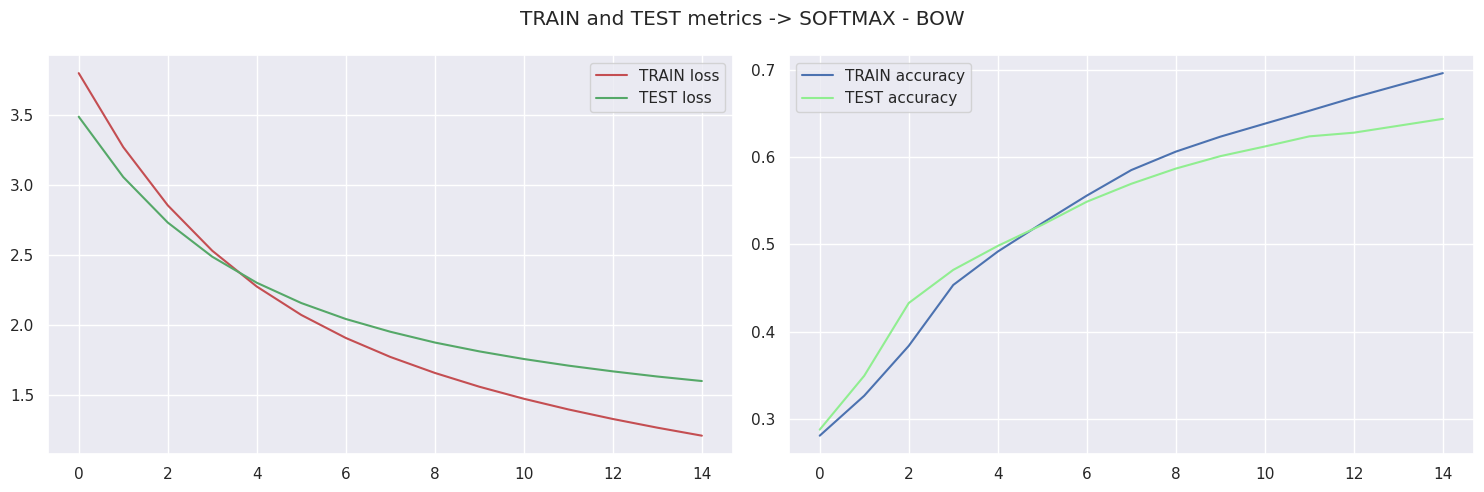



CONFUSION MATRIX: 
[[1253   67   76  205]
 [ 112   11   10   28]
 [  50    2   10   27]
 [ 207   26   32  253]]


REPORT: 
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1601
           1       0.10      0.07      0.08       161
           2       0.08      0.11      0.09        89
           3       0.49      0.49      0.49       518

    accuracy                           0.64      2369
   macro avg       0.36      0.36      0.36      2369
weighted avg       0.64      0.64      0.64      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.21736414740787008,
    "far": 0.48046875
  },
  "1": {
    "frr": 0.9316770186335404,
    "far": 0.043025362318840576
  },
  "2": {
    "frr": 0.8876404494382022,
    "far": 0.05175438596491228
  },
  "3": {
    "frr": 0.5115830115830116,
    "far": 0.14046461372231225
  }
}


In [109]:
model_and_report(softmax_simple_bow, softmax_simple_bow_result, X_test_bow.toarray(), y_test, "SOFTMAX - BOW")

### TF-IDF words n-gram sequences

In [110]:
softmax_simple_tfidf_w = single_layer_softmax_model(X_train_tfidf_w.toarray().shape)
softmax_simple_tfidf_w_result = softmax_simple_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


75/75 [==============================] - 0s 633us/step
MODEL: SOFTMAX - TFIDF + n-gram words(1,4)
On TEST accuracy: 0.7289995551109314
TRAIN Accuracy: 74.373% 



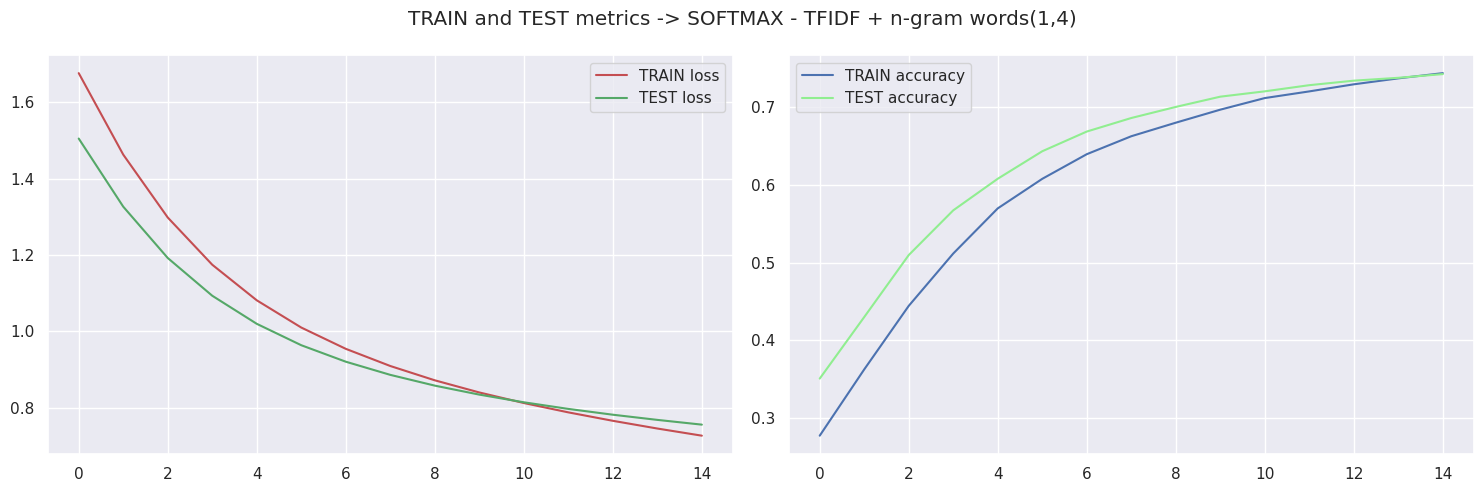



CONFUSION MATRIX: 
[[1465    8   11  117]
 [ 137    4    2   18]
 [  58    0    3   28]
 [ 255    5    3  255]]


REPORT: 
              precision    recall  f1-score   support

           0       0.77      0.92      0.83      1601
           1       0.24      0.02      0.04       161
           2       0.16      0.03      0.06        89
           3       0.61      0.49      0.54       518

    accuracy                           0.73      2369
   macro avg       0.44      0.37      0.37      2369
weighted avg       0.67      0.73      0.69      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.08494690818238601,
    "far": 0.5859375
  },
  "1": {
    "frr": 0.9751552795031055,
    "far": 0.00588768115942029
  },
  "2": {
    "frr": 0.9662921348314607,
    "far": 0.007017543859649123
  },
  "3": {
    "frr": 0.5077220077220077,
    "far": 0.08806050783360346
  }
}


In [111]:
model_and_report(softmax_simple_tfidf_w, 
                 softmax_simple_tfidf_w_result, 
                 X_test_tfidf_w.toarray(), 
                 y_test, 
                 "SOFTMAX - TFIDF + n-gram words(1,4)")

### TF-IDF char n-grams

In [112]:
softmax_simple_tfidf_c = single_layer_softmax_model(X_train_tfidf_c.toarray().shape)
softmax_simple_tfidf_c_result = softmax_simple_tfidf_c.fit(
    X_train_tfidf_c.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


75/75 [==============================] - 0s 2ms/step
MODEL: SOFTMAX - TFIDF + n-gram chars(3,5)
On TEST accuracy: 0.7555930614471436
TRAIN Accuracy: 84.125% 



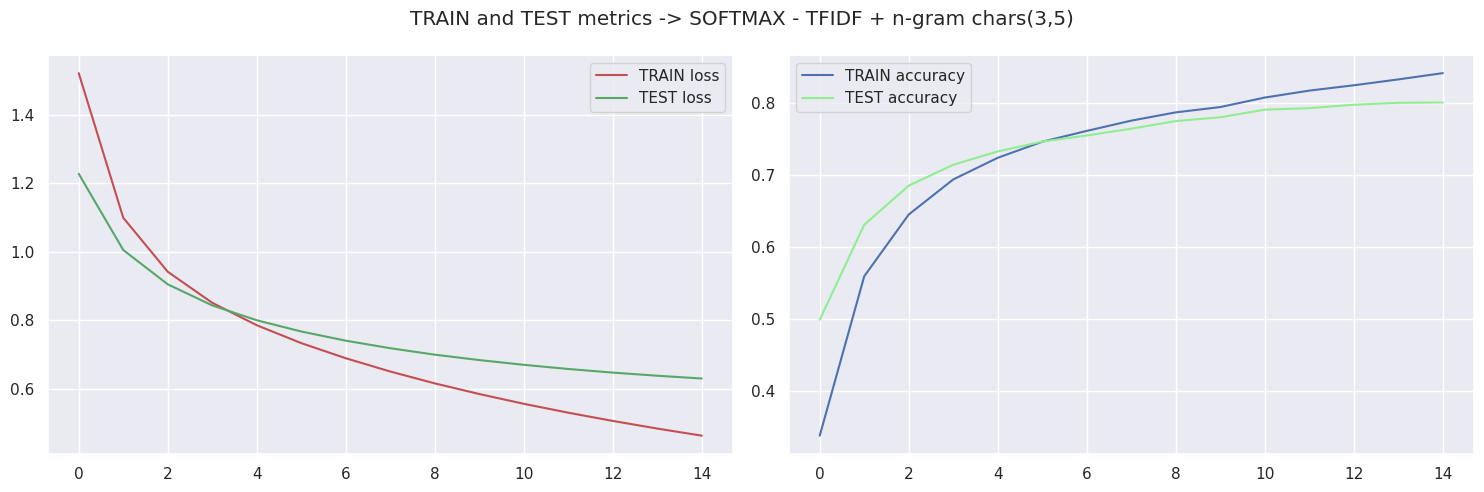



CONFUSION MATRIX: 
[[1456   22   13  110]
 [ 127   13    0   21]
 [  41    1   12   35]
 [ 193    7    9  309]]


REPORT: 
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1601
           1       0.30      0.08      0.13       161
           2       0.35      0.13      0.20        89
           3       0.65      0.60      0.62       518

    accuracy                           0.76      2369
   macro avg       0.53      0.43      0.45      2369
weighted avg       0.72      0.76      0.73      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.0905683947532792,
    "far": 0.4700520833333333
  },
  "1": {
    "frr": 0.9192546583850931,
    "far": 0.01358695652173913
  },
  "2": {
    "frr": 0.8651685393258427,
    "far": 0.009649122807017544
  },
  "3": {
    "frr": 0.4034749034749035,
    "far": 0.08968125337655321
  }
}


In [113]:
model_and_report(softmax_simple_tfidf_c, 
                 softmax_simple_tfidf_c_result, 
                 X_test_tfidf_c.toarray(), 
                 y_test, 
                 "SOFTMAX - TFIDF + n-gram chars(3,5)")

### Word2Vec

In [114]:
softmax_simple_w2v = single_layer_softmax_model(np.array(X_train_w2v_avg).shape)
softmax_simple_w2v_result = softmax_simple_w2v.fit(
    np.array(X_train_w2v_avg), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


75/75 [==============================] - 0s 508us/step
MODEL: SOFTMAX - WORD2VEC
On TEST accuracy: 0.7104263305664062
TRAIN Accuracy: 73.423% 



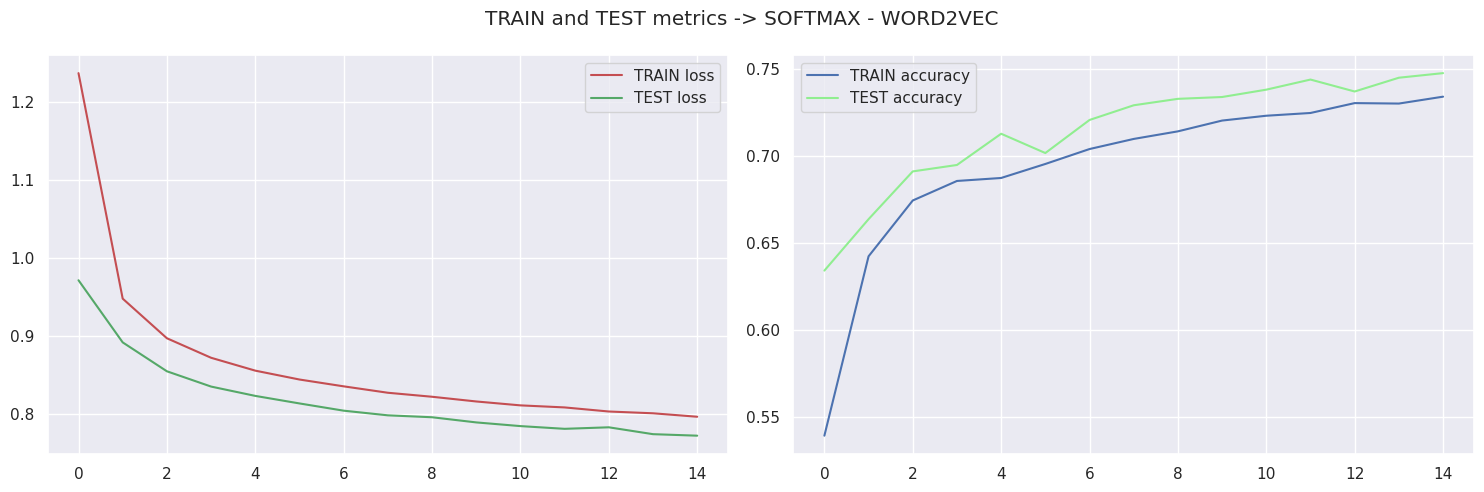



CONFUSION MATRIX: 
[[1491    0    0  110]
 [ 158    0    0    3]
 [  83    0    0    6]
 [ 326    0    0  192]]


REPORT: 
              precision    recall  f1-score   support

           0       0.72      0.93      0.81      1601
           1       0.00      0.00      0.00       161
           2       0.00      0.00      0.00        89
           3       0.62      0.37      0.46       518

    accuracy                           0.71      2369
   macro avg       0.34      0.33      0.32      2369
weighted avg       0.62      0.71      0.65      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.06870705808869457,
    "far": 0.73828125
  },
  "1": {
    "frr": 1.0,
    "far": 0.0
  },
  "2": {
    "frr": 1.0,
    "far": 0.0
  },
  "3": {
    "frr": 0.6293436293436293,
    "far": 0.06428957320367369
  }
}


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
model_and_report(softmax_simple_w2v, 
                 softmax_simple_w2v_result, 
                 np.array(X_test_w2v_avg), 
                 y_test, 
                 "SOFTMAX - WORD2VEC")

### N-gram word groups

In [116]:
# X_train_tfidf_wg, X_test_tfidf_wg
softmax_simple_tfidf_wg = single_layer_softmax_model(X_train_tfidf_wg.toarray().shape)
softmax_simple_tfidf_wg_result = softmax_simple_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


75/75 [==============================] - 0s 813us/step
MODEL: SOFTMAX - WORD GROUPS
On TEST accuracy: 0.68636554479599
TRAIN Accuracy: 69.9% 



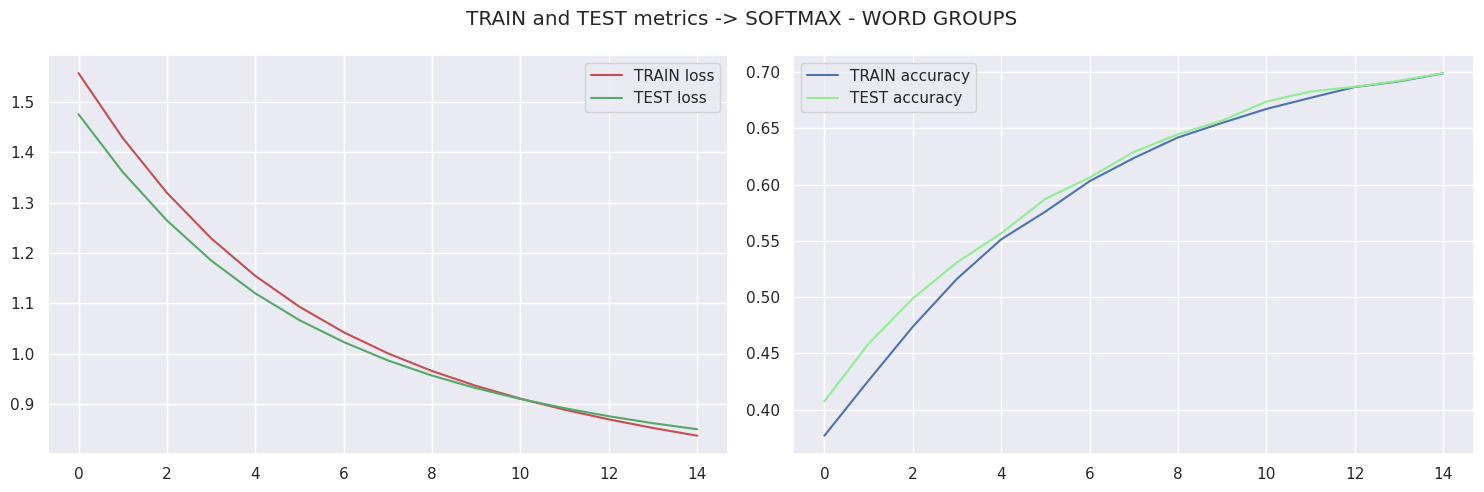



CONFUSION MATRIX: 
[[1472   14   20   95]
 [ 150    1    2    8]
 [  72    1    2   14]
 [ 360    2    5  151]]


REPORT: 
              precision    recall  f1-score   support

           0       0.72      0.92      0.81      1601
           1       0.06      0.01      0.01       161
           2       0.07      0.02      0.03        89
           3       0.56      0.29      0.38       518

    accuracy                           0.69      2369
   macro avg       0.35      0.31      0.31      2369
weighted avg       0.61      0.69      0.63      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.08057464084946908,
    "far": 0.7578125
  },
  "1": {
    "frr": 0.9937888198757764,
    "far": 0.007699275362318841
  },
  "2": {
    "frr": 0.9775280898876404,
    "far": 0.011842105263157895
  },
  "3": {
    "frr": 0.7084942084942085,
    "far": 0.06320907617504051
  }
}


In [117]:
model_and_report(softmax_simple_tfidf_wg, 
                 softmax_simple_tfidf_wg_result, 
                 X_test_tfidf_wg.toarray(), 
                 y_test, 
                 "SOFTMAX - WORD GROUPS")

## Multi-layer deep neural network

In [118]:
def deep_multilayer_model(input_shape, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(input_shape[1],)),
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0),
                              kernel_regularizer="l2",
                              activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256,
#                               kernel_regularizer="l2",
                              activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(# Adam + crossentropy
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

### BOW

In [119]:
multi_layer_bow = deep_multilayer_model(X_train_bow.toarray().shape)
multi_layer_bow_result = multi_layer_bow.fit(
    X_train_bow.toarray(),
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

75/75 [==============================] - 0s 5ms/step
MODEL: MULTI-LAYER - BOW
On TEST accuracy: 0.7496834397315979
TRAIN Accuracy: 97.202% 



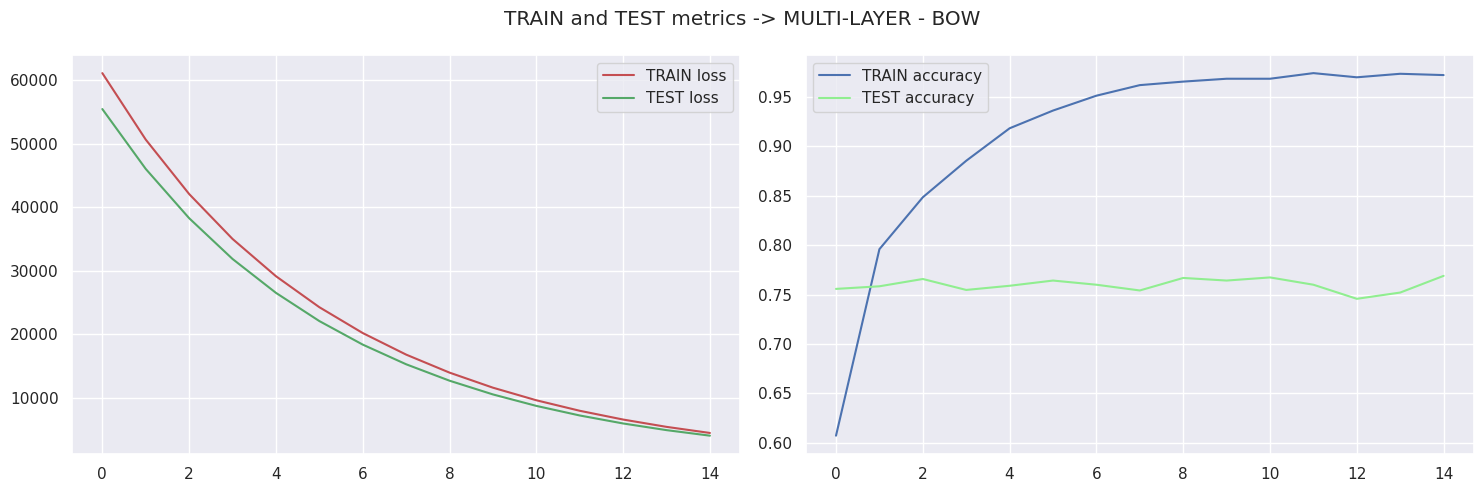



CONFUSION MATRIX: 
[[1443   27   21  110]
 [ 130   19    0   12]
 [  52    3   11   23]
 [ 198    9    8  303]]


REPORT: 
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1601
           1       0.33      0.12      0.17       161
           2       0.28      0.12      0.17        89
           3       0.68      0.58      0.63       518

    accuracy                           0.75      2369
   macro avg       0.52      0.43      0.45      2369
weighted avg       0.72      0.75      0.72      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.09868831980012492,
    "far": 0.4947916666666667
  },
  "1": {
    "frr": 0.8819875776397516,
    "far": 0.017663043478260868
  },
  "2": {
    "frr": 0.8764044943820225,
    "far": 0.012719298245614035
  },
  "3": {
    "frr": 0.41505791505791506,
    "far": 0.07833603457590492
  }
}


In [120]:
model_and_report(multi_layer_bow, 
                 multi_layer_bow_result, 
                 X_test_bow.toarray(), 
                 y_test, 
                 "MULTI-LAYER - BOW")

### TFIDF n-gram words 

In [121]:
deep_multilayer_model_tfidf_w = deep_multilayer_model(X_train_tfidf_w.toarray().shape)
deep_multilayer_model_tfidf_w_result = deep_multilayer_model_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 3ms/step
MODEL: MULTI-LAYER - TF-IDF WORD n-gram
On TEST accuracy: 0.7323765158653259
TRAIN Accuracy: 97.612% 



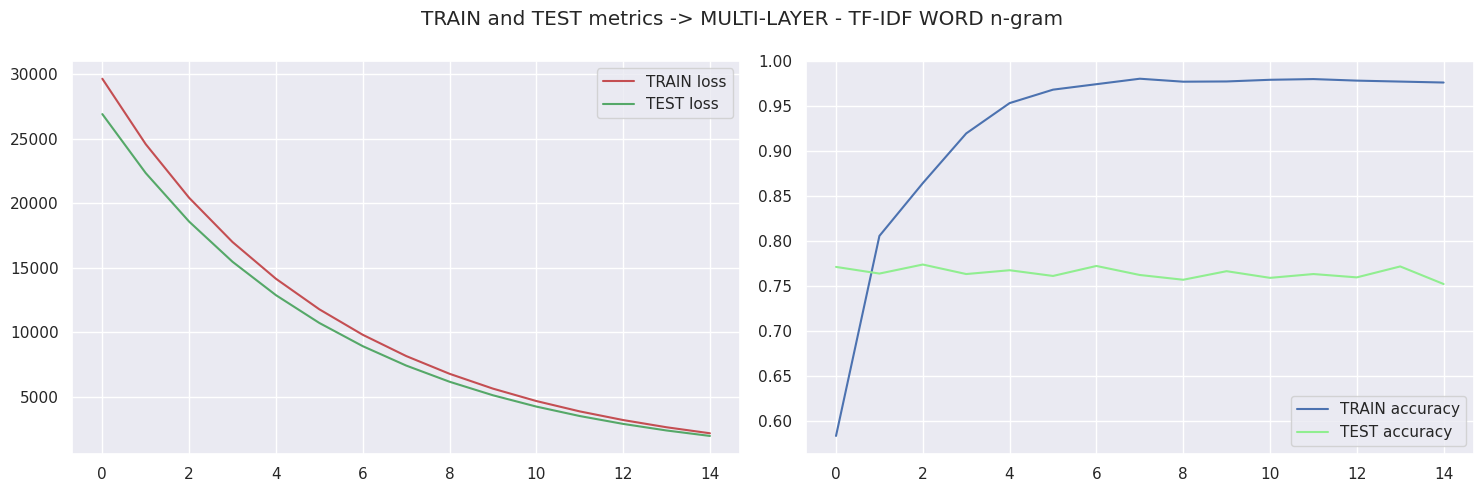



CONFUSION MATRIX: 
[[1419   46   23  113]
 [ 117   20    5   19]
 [  52    0   16   21]
 [ 211   13   14  280]]


REPORT: 
              precision    recall  f1-score   support

           0       0.79      0.89      0.83      1601
           1       0.25      0.12      0.17       161
           2       0.28      0.18      0.22        89
           3       0.65      0.54      0.59       518

    accuracy                           0.73      2369
   macro avg       0.49      0.43      0.45      2369
weighted avg       0.70      0.73      0.71      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.1136789506558401,
    "far": 0.4947916666666667
  },
  "1": {
    "frr": 0.8757763975155279,
    "far": 0.026721014492753624
  },
  "2": {
    "frr": 0.8202247191011236,
    "far": 0.018421052631578946
  },
  "3": {
    "frr": 0.4594594594594595,
    "far": 0.08265802269043761
  }
}


In [122]:
model_and_report(deep_multilayer_model_tfidf_w, 
                 deep_multilayer_model_tfidf_w_result, 
                 X_test_tfidf_w.toarray(), 
                 y_test, 
                 "MULTI-LAYER - TF-IDF WORD n-gram")

### TF-IDF Char n-grams

In [123]:
softmax_simple_tfidf_c = deep_multilayer_model(X_train_tfidf_c.toarray().shape)
softmax_simple_tfidf_c_result = softmax_simple_tfidf_c.fit(
    X_train_tfidf_c.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 22s 179ms/step - loss: 218560.7656 - accuracy: 0.5941 - val_loss: 198335.3281 - val_accuracy: 0.7641
Epoch 2/15
119/119 [==============================] - 21s 178ms/step - loss: 181145.4219 - accuracy: 0.8040 - val_loss: 164625.3906 - val_accuracy: 0.7805
Epoch 3/15
119/119 [==============================] - 21s 173ms/step - loss: 150495.0312 - accuracy: 0.8715 - val_loss: 136882.8906 - val_accuracy: 0.7731
Epoch 4/15
119/119 [==============================] - 21s 178ms/step - loss: 125195.1953 - accuracy: 0.9272 - val_loss: 113919.5156 - val_accuracy: 0.7704
Epoch 5/15
119/119 [==============================] - 22s 183ms/step - loss: 104213.8203 - accuracy: 0.9611 - val_loss: 94841.3203 - val_accuracy: 0.7588
Epoch 6/15
119/119 [==============================] - 21s 178ms/step - loss: 86760.1406 - accuracy: 0.9777 - val_loss: 78951.5312 - val_accuracy: 0.7720
Epoch 7/15
119/119 [==============================] - 21s 179ms/step - lo

75/75 [==============================] - 1s 15ms/step
MODEL: MULTI-LAYER - CHAR N-GRAMS
On TEST accuracy: 0.7323765158653259
TRAIN Accuracy: 98.1% 



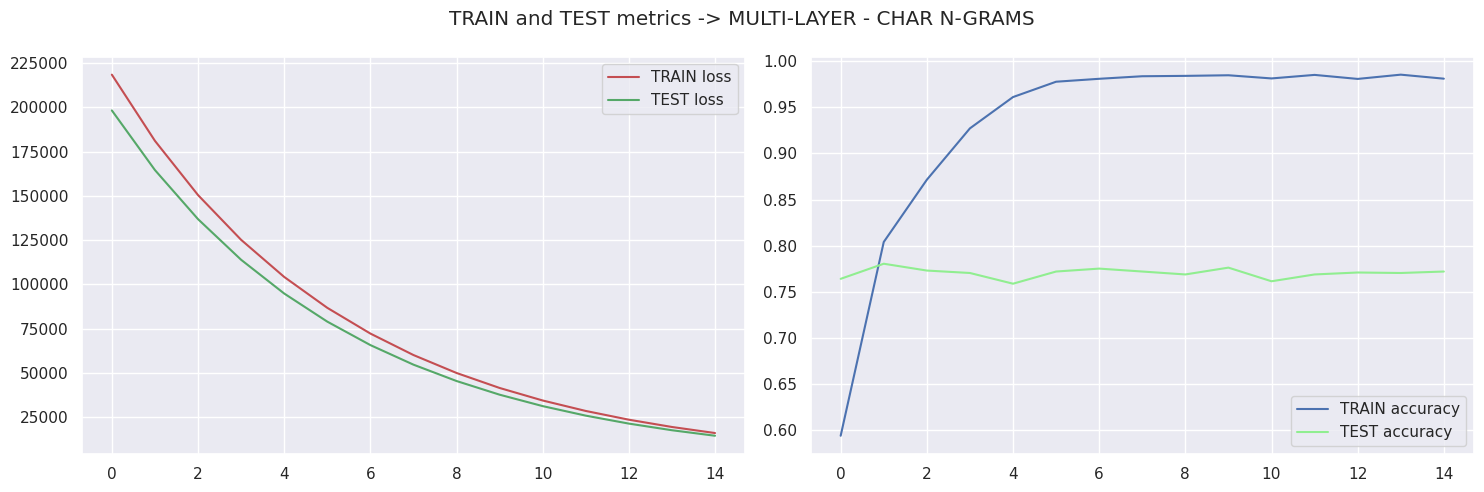



CONFUSION MATRIX: 
[[1425   43   21  112]
 [ 125   24    3    9]
 [  53    0   10   26]
 [ 222   12    8  276]]


REPORT: 
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1601
           1       0.30      0.15      0.20       161
           2       0.24      0.11      0.15        89
           3       0.65      0.53      0.59       518

    accuracy                           0.73      2369
   macro avg       0.49      0.42      0.44      2369
weighted avg       0.70      0.73      0.71      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.1099312929419113,
    "far": 0.5208333333333334
  },
  "1": {
    "frr": 0.8509316770186336,
    "far": 0.024909420289855072
  },
  "2": {
    "frr": 0.8876404494382022,
    "far": 0.014035087719298246
  },
  "3": {
    "frr": 0.4671814671814672,
    "far": 0.07941653160453808
  }
}


In [124]:
model_and_report(softmax_simple_tfidf_c, 
                 softmax_simple_tfidf_c_result, 
                 X_test_tfidf_c.toarray(), 
                 y_test, 
                 "MULTI-LAYER - CHAR N-GRAMS")

### Word2Vec

In [125]:
deep_multilayer_model_w2v = deep_multilayer_model(np.array(X_train_w2v_avg).shape)
deep_multilayer_model_w2v_result = deep_multilayer_model_w2v.fit(
    np.array(X_train_w2v_avg), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 1s 6ms/step - loss: 4679.1479 - accuracy: 0.6719 - val_loss: 4247.5825 - val_accuracy: 0.5704
Epoch 2/15
119/119 [==============================] - 1s 7ms/step - loss: 3880.2520 - accuracy: 0.7457 - val_loss: 3527.4180 - val_accuracy: 0.7631
Epoch 3/15
119/119 [==============================] - 1s 7ms/step - loss: 3225.6274 - accuracy: 0.7453 - val_loss: 2934.8362 - val_accuracy: 0.7652
Epoch 4/15
119/119 [==============================] - 1s 7ms/step - loss: 2685.1365 - accuracy: 0.7474 - val_loss: 2444.1956 - val_accuracy: 0.7515
Epoch 5/15
119/119 [==============================] - 1s 7ms/step - loss: 2236.7905 - accuracy: 0.7472 - val_loss: 2036.4530 - val_accuracy: 0.7646
Epoch 6/15
119/119 [==============================] - 1s 6ms/step - loss: 1863.7246 - accuracy: 0.7484 - val_loss: 1696.7456 - val_accuracy: 0.7599
Epoch 7/15
119/119 [==============================] - 1s 7ms/step - loss: 1552.6259 - accuracy: 0.7520 - val_los

75/75 [==============================] - 0s 1ms/step
MODEL: MULTI-LAYER - WORD2VEC
On TEST accuracy: 0.6977627873420715
TRAIN Accuracy: 75.468% 



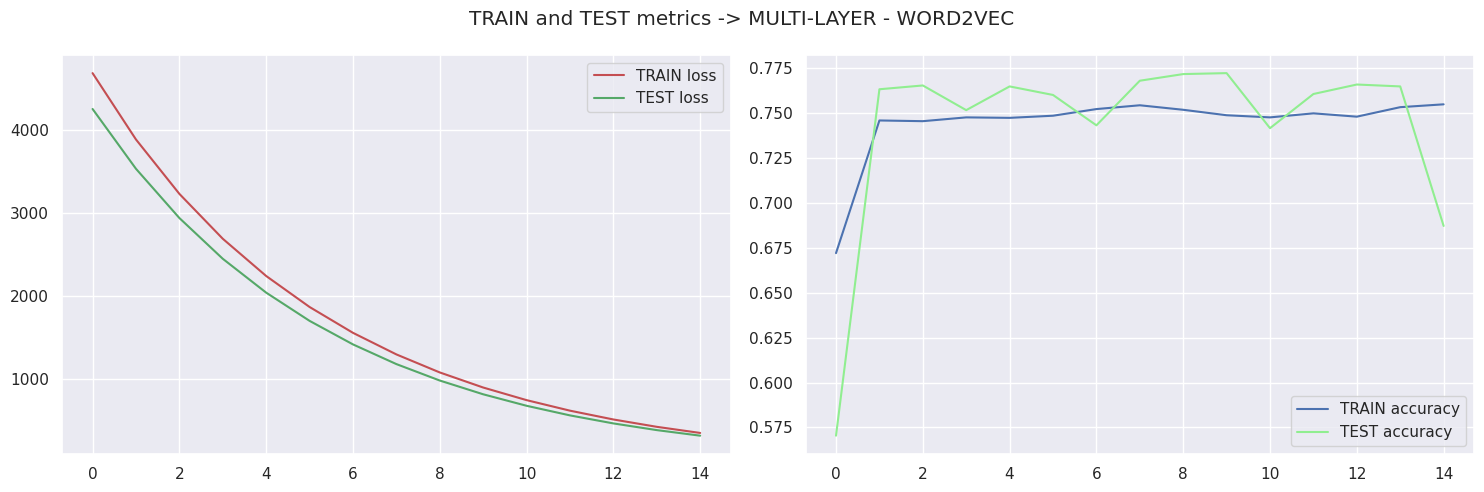



CONFUSION MATRIX: 
[[1396    0  107   98]
 [ 144    0   15    2]
 [  66    0    9   14]
 [ 243    0   27  248]]


REPORT: 
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1601
           1       0.00      0.00      0.00       161
           2       0.06      0.10      0.07        89
           3       0.69      0.48      0.56       518

    accuracy                           0.70      2369
   macro avg       0.37      0.36      0.36      2369
weighted avg       0.66      0.70      0.67      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.12804497189256714,
    "far": 0.58984375
  },
  "1": {
    "frr": 1.0,
    "far": 0.0
  },
  "2": {
    "frr": 0.898876404494382,
    "far": 0.06535087719298245
  },
  "3": {
    "frr": 0.5212355212355212,
    "far": 0.06158833063209076
  }
}


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [126]:
model_and_report(deep_multilayer_model_w2v, 
                 deep_multilayer_model_w2v_result, 
                 np.array(X_test_w2v_avg), 
                 y_test, 
                 "MULTI-LAYER - WORD2VEC")

#### With generalized dataset

## Multi-layer model with dropout regularization

In [127]:
def deep_multilayer_with_dropout_model(input_shape, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(#loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
        loss="categorical_crossentropy",
        metrics=["accuracy"])
    
    return model

### BOW

In [128]:
multi_layer_dropout_bow = deep_multilayer_with_dropout_model(X_train_bow.toarray().shape)
multi_layer_dropout_bow_result = multi_layer_dropout_bow.fit(
    X_train_bow.toarray(),
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=True)

Epoch 1/15
119/119 [==============================] - 4s 28ms/step - loss: 7.3512 - accuracy: 0.6331 - val_loss: 6.2445 - val_accuracy: 0.6839
Epoch 2/15
119/119 [==============================] - 3s 29ms/step - loss: 5.3947 - accuracy: 0.7772 - val_loss: 4.8059 - val_accuracy: 0.7620
Epoch 3/15
119/119 [==============================] - 4s 30ms/step - loss: 4.0755 - accuracy: 0.8129 - val_loss: 3.8550 - val_accuracy: 0.7773
Epoch 4/15
119/119 [==============================] - 4s 30ms/step - loss: 3.2337 - accuracy: 0.8294 - val_loss: 3.1880 - val_accuracy: 0.8032
Epoch 5/15
119/119 [==============================] - 4s 30ms/step - loss: 2.7431 - accuracy: 0.8475 - val_loss: 2.8845 - val_accuracy: 0.7937
Epoch 6/15
119/119 [==============================] - 3s 29ms/step - loss: 2.4867 - accuracy: 0.8542 - val_loss: 2.9151 - val_accuracy: 0.7150
Epoch 7/15
119/119 [==============================] - 3s 28ms/step - loss: 2.3645 - accuracy: 0.8699 - val_loss: 2.9099 - val_accuracy: 0.6950

75/75 [==============================] - 0s 6ms/step
MODEL: MULTI-LAYER + DROPOUT - BOW
On TEST accuracy: 0.672013521194458
TRAIN Accuracy: 87.596% 



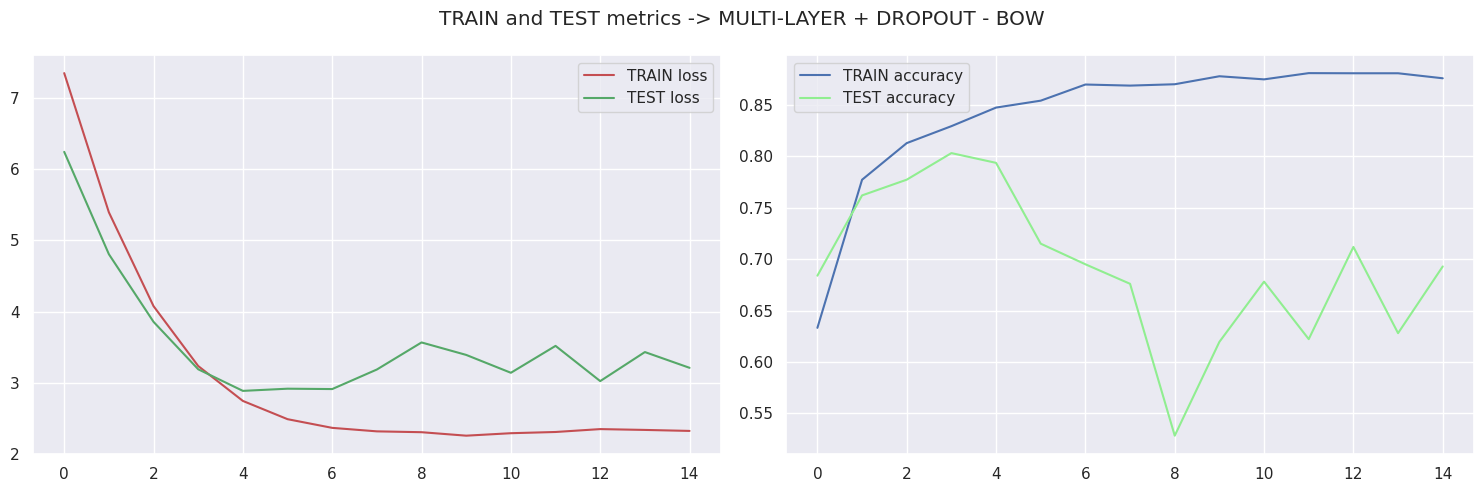



CONFUSION MATRIX: 
[[1122  131   74  274]
 [  63   61    4   33]
 [  13    6   40   30]
 [  81   31   37  369]]


REPORT: 
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1601
           1       0.27      0.38      0.31       161
           2       0.26      0.45      0.33        89
           3       0.52      0.71      0.60       518

    accuracy                           0.67      2369
   macro avg       0.48      0.56      0.51      2369
weighted avg       0.73      0.67      0.69      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.29918800749531543,
    "far": 0.20442708333333334
  },
  "1": {
    "frr": 0.6211180124223602,
    "far": 0.07608695652173914
  },
  "2": {
    "frr": 0.550561797752809,
    "far": 0.05043859649122807
  },
  "3": {
    "frr": 0.2876447876447876,
    "far": 0.18206374932468936
  }
}


In [129]:
model_and_report(multi_layer_dropout_bow, 
                 multi_layer_dropout_bow_result, 
                 X_test_bow.toarray(), 
                 y_test, 
                 "MULTI-LAYER + DROPOUT - BOW")

### TF-IDF

In [130]:
multi_layer_dropout_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape, learning_rate=0.0001)
multi_layer_dropout_tfidf_wg_result = multi_layer_dropout_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 2s 10ms/step - loss: 13.7816 - accuracy: 0.3399 - val_loss: 12.1213 - val_accuracy: 0.6839
Epoch 2/15
119/119 [==============================] - 1s 11ms/step - loss: 11.8079 - accuracy: 0.4926 - val_loss: 11.0056 - val_accuracy: 0.6839
Epoch 3/15
119/119 [==============================] - 1s 12ms/step - loss: 10.8237 - accuracy: 0.5715 - val_loss: 10.2852 - val_accuracy: 0.6839
Epoch 4/15
119/119 [==============================] - 1s 12ms/step - loss: 10.1243 - accuracy: 0.6127 - val_loss: 9.7036 - val_accuracy: 0.6913
Epoch 5/15
119/119 [==============================] - 1s 12ms/step - loss: 9.5620 - accuracy: 0.6291 - val_loss: 9.1813 - val_accuracy: 0.7077
Epoch 6/15
119/119 [==============================] - 1s 11ms/step - loss: 9.0717 - accuracy: 0.6390 - val_loss: 8.6891 - val_accuracy: 0.7272
Epoch 7/15
119/119 [==============================] - 1s 11ms/step - loss: 8.6082 - accuracy: 0.6533 - val_loss: 8.2515 - val_accuracy:

75/75 [==============================] - 0s 2ms/step
MODEL: MULTI-LAYER + DROPOUT - TFIDF - word groups
On TEST accuracy: 0.7425073981285095
TRAIN Accuracy: 73.489% 



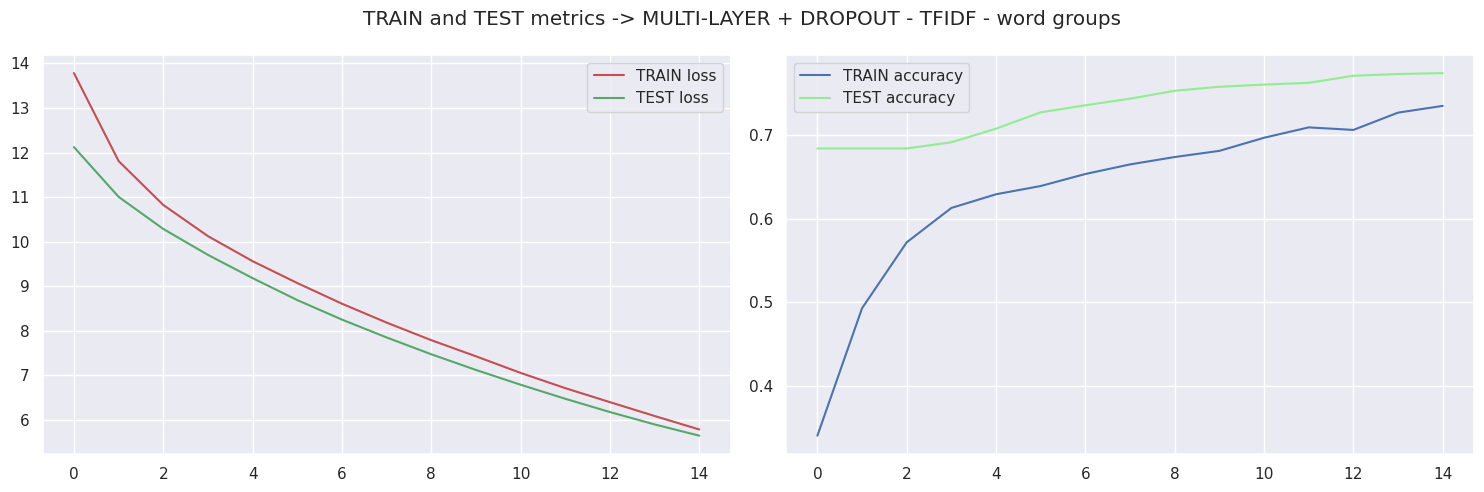



CONFUSION MATRIX: 
[[1471    1    0  129]
 [ 144    0    0   17]
 [  56    0    0   33]
 [ 230    0    0  288]]


REPORT: 
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1601
           1       0.00      0.00      0.00       161
           2       0.00      0.00      0.00        89
           3       0.62      0.56      0.58       518

    accuracy                           0.74      2369
   macro avg       0.35      0.37      0.36      2369
weighted avg       0.66      0.74      0.70      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.08119925046845722,
    "far": 0.5598958333333334
  },
  "1": {
    "frr": 1.0,
    "far": 0.0004528985507246377
  },
  "2": {
    "frr": 1.0,
    "far": 0.0
  },
  "3": {
    "frr": 0.444015444015444,
    "far": 0.09670448406266882
  }
}


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
model_and_report(multi_layer_dropout_tfidf_wg, 
                 multi_layer_dropout_tfidf_wg_result, 
                 X_test_tfidf_wg.toarray(), 
                 y_test, 
                 "MULTI-LAYER + DROPOUT - TFIDF - word groups")

#### Усі групи слів

In [132]:
multi_layer_dropout_tfidf_w = deep_multilayer_with_dropout_model(X_train_tfidf_w.toarray().shape)
multi_layer_dropout_tfidf_w_result = multi_layer_dropout_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 4ms/step
MODEL: MULTI-LAYER + DROPOUT - TFIDF words
On TEST accuracy: 0.7399746775627136
TRAIN Accuracy: 86.091% 



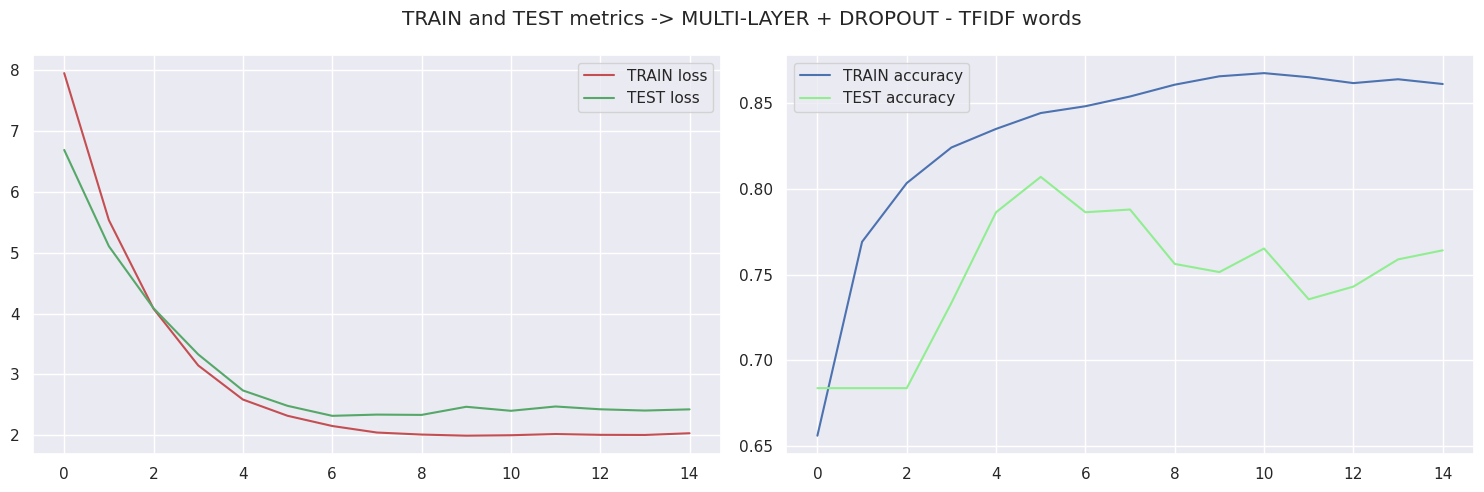



CONFUSION MATRIX: 
[[1338   52   38  173]
 [  84   36    4   37]
 [  31    2   27   29]
 [ 132   11   23  352]]


REPORT: 
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1601
           1       0.36      0.22      0.27       161
           2       0.29      0.30      0.30        89
           3       0.60      0.68      0.63       518

    accuracy                           0.74      2369
   macro avg       0.52      0.51      0.51      2369
weighted avg       0.74      0.74      0.74      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.16427232979387882,
    "far": 0.3216145833333333
  },
  "1": {
    "frr": 0.7763975155279503,
    "far": 0.029438405797101448
  },
  "2": {
    "frr": 0.6966292134831461,
    "far": 0.02850877192982456
  },
  "3": {
    "frr": 0.3204633204633205,
    "far": 0.12911939492166397
  }
}


In [133]:
model_and_report(multi_layer_dropout_tfidf_w, 
                 multi_layer_dropout_tfidf_w_result, 
                 X_test_tfidf_w.toarray(), 
                 y_test, 
                 "MULTI-LAYER + DROPOUT - TFIDF words")

### Word2Vec

In [134]:
multi_layer_dropout_w2v = deep_multilayer_with_dropout_model(np.array(X_train_w2v_avg).shape)
multi_layer_dropout_w2v_result = multi_layer_dropout_w2v.fit(
    np.array(X_train_w2v_avg), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 1ms/step
MODEL: MULTI-LAYER + DROPOUT - WORD2VEC
On TEST accuracy: 0.7129590511322021
TRAIN Accuracy: 72.473% 



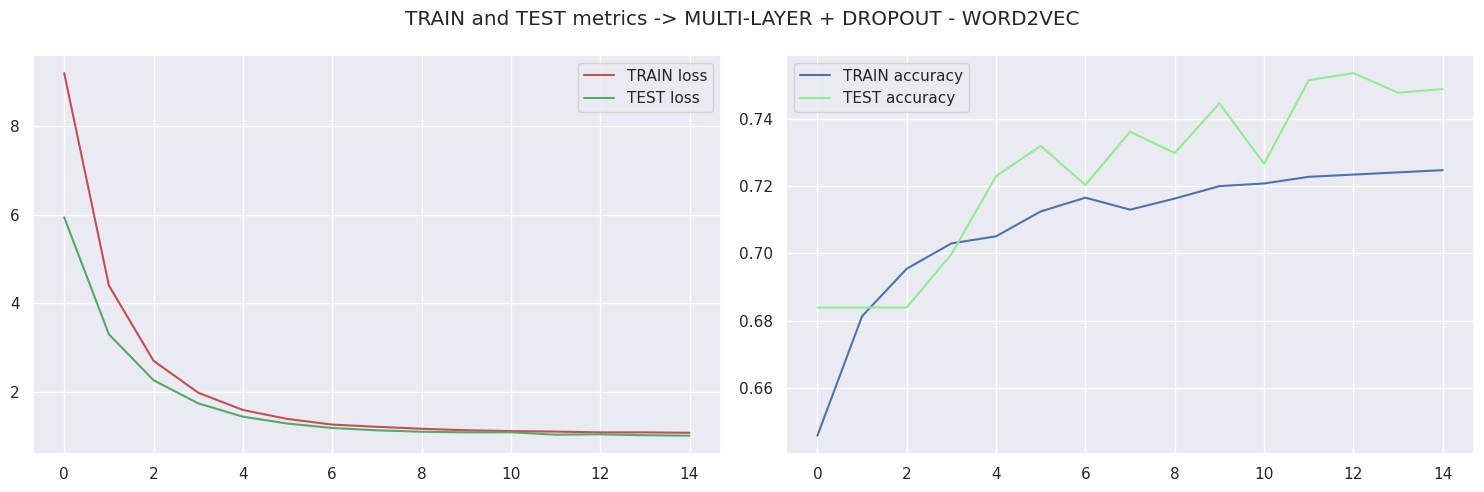



CONFUSION MATRIX: 
[[1483    0    0  118]
 [ 159    0    0    2]
 [  80    0    0    9]
 [ 312    0    0  206]]


REPORT: 
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      1601
           1       0.00      0.00      0.00       161
           2       0.00      0.00      0.00        89
           3       0.61      0.40      0.48       518

    accuracy                           0.71      2369
   macro avg       0.34      0.33      0.32      2369
weighted avg       0.63      0.71      0.66      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.07370393504059962,
    "far": 0.7174479166666666
  },
  "1": {
    "frr": 1.0,
    "far": 0.0
  },
  "2": {
    "frr": 1.0,
    "far": 0.0
  },
  "3": {
    "frr": 0.6023166023166023,
    "far": 0.06969205834683954
  }
}


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [135]:
model_and_report(multi_layer_dropout_w2v, 
                 multi_layer_dropout_w2v_result, 
                 np.array(X_test_w2v_avg), 
                 y_test, 
                 "MULTI-LAYER + DROPOUT - WORD2VEC")

## Deep CNN

In [139]:
def deep_cnn_model(input_shape, learning_rate=0.001):
    model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=(input_shape[1],)),
        tf.keras.layers.Conv1D(512, 2, activation="relu", padding="same", input_shape=(input_shape[1],1)),
        tf.keras.layers.AveragePooling1D(pool_size=3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(256, 2, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.AveragePooling1D(pool_size=3),
        tf.keras.layers.MaxPool1D(pool_size=3),
        tf.keras.layers.Conv1D(128, 2, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, 2, activation="relu", padding="same"),
        tf.keras.layers.AveragePooling1D(pool_size=3, padding="same"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l2"),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    
    return model

## BOW

In [140]:
y_train.argmax(axis=1)

array([0, 0, 0, ..., 3, 0, 0])

In [141]:
deep_cnn_bow = deep_cnn_model(X_train_bow.toarray().shape)
deep_cnn_bow_result = deep_cnn_bow.fit(
    X_train_bow.toarray(),
    y_train.argmax(axis=1), 
    epochs=4, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=True)

Epoch 1/4
 27/119 [=====>........................] - ETA: 8:51 - loss: 1.1370 - accuracy: 0.5515

KeyboardInterrupt: 

75/75 [==============================] - 38s 504ms/step - loss: 0.9931 - accuracy: 0.6737
DEEP CNN - BOW
On TEST accuracy: 0.6737020015716553
TRAIN Accuracy: 93.138% 



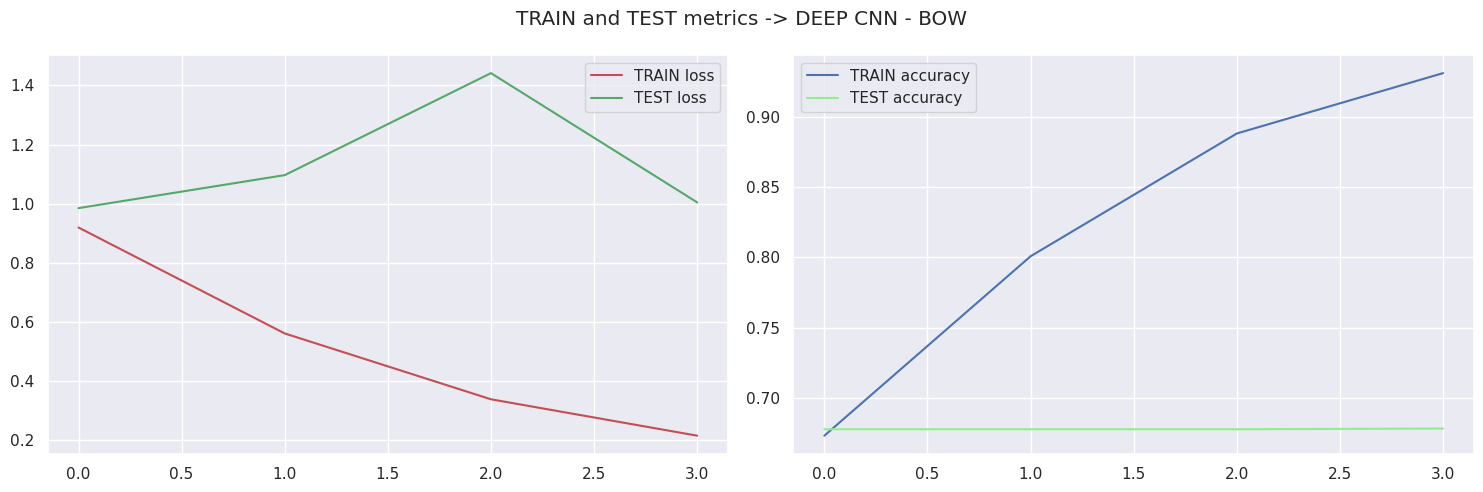



CONFUSION MATRIX
[[1595    0    0    0]
 [ 154    0    0    0]
 [  80    0    0    0]
 [ 539    0    0    1]]


REPORT: 
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      1595
           1       0.00      0.00      0.00       154
           2       0.00      0.00      0.00        80
           3       1.00      0.00      0.00       540

    accuracy                           0.67      2369
   macro avg       0.42      0.25      0.20      2369
weighted avg       0.68      0.67      0.54      2369



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [138]:
deep_cnn_bow_y_pred = deep_cnn_bow.predict(X_test_bow.toarray(), verbose=True)
_, deep_cnn_bow_accuracy = deep_cnn_bow.evaluate(X_test_bow.toarray(), 
                                      y_test, verbose=True)

print("DEEP CNN - BOW")
print(f"On TEST accuracy: {deep_cnn_bow_accuracy}")
plot_learning_metrics(deep_cnn_bow_result, "DEEP CNN - BOW", epochs=4)

print("\n\nCONFUSION MATRIX")
print(show_confusion_matrix(y_test.argmax(axis=1), np.argmax(deep_cnn_bow_y_pred, axis=1)))

print("\n\nREPORT: ")
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(deep_cnn_bow_y_pred, axis=1)))

### Char n-grams CNN

In [139]:
AUTOTUNE = tf.data.AUTOTUNE
def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [140]:
X_train_tfidf_rc_optim = configure_dataset(tf.data.Dataset.from_tensor_slices(X_train_tfidf_rc.toarray()))

2023-05-08 17:54:59.205766: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10980495328 exceeds 10% of free system memory.


In [ ]:
# X_train_tfidf_rc, X_test_tfidf_rc,
deep_cnn_tfidf_c = deep_cnn_model(X_train_tfidf_c.toarray().shape)
deep_cnn_tfidf_c_result = deep_cnn_tfidf_c.fit(
    X_train_tfidf_c.toarray(),
    y_train, 
    epochs=4, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=True)

In [ ]:
deep_cnn_bow_y_pred = deep_cnn_bow.predict(X_test_bow.toarray(), verbose=True)
_, deep_cnn_bow_accuracy = deep_cnn_bow.evaluate(X_test_bow.toarray(), 
                                      y_test, verbose=True)

print("DEEP CNN - BOW")
print(f"On TEST accuracy: {deep_cnn_bow_accuracy}")
plot_learning_metrics(deep_cnn_bow_result, "DEEP CNN - BOW", epochs=4)

print("\n\nCONFUSION MATRIX")
print(show_confusion_matrix(y_test.argmax(axis=1), np.argmax(deep_cnn_bow_y_pred, axis=1)))

print("\n\nREPORT: ")
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(deep_cnn_bow_y_pred, axis=1)))

### TF-IDF

#### Тільки словосполучення

In [ ]:
deep_cnn_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape)
deep_cnn_tfidf_wg_result = deep_cnn_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

In [ ]:
_, deep_cnn_tfidf_wg_accuracy = deep_cnn_tfidf_wg.evaluate(X_test_tfidf_wg.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - TF-IDF WG")
print(f"On TEST accuracy: {deep_cnn_tfidf_wg_accuracy}")
plot_learning_metrics(deep_cnn_tfidf_wg_result, "CNN WG")

#### Усі групи слів

In [ ]:
deep_cnn_tfidf_w = deep_multilayer_with_dropout_model(X_train_tfidf_w.toarray().shape)
deep_cnn_tfidf_w_result = deep_cnn_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

In [ ]:
_, deep_cnn_tfidf_w_accuracy = deep_cnn_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - TF-IDF")
print(f"On TEST accuracy: {deep_cnn_tfidf_w_accuracy}")
plot_learning_metrics(deep_cnn_tfidf_w_result, "CNN")

### Word2vec

In [ ]:
deep_cnn_w2v = deep_cnn_model(np.array(X_train_w2v_avg).shape, learning_rate=0.00001)
deep_cnn_w2v_result = deep_cnn_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

In [ ]:
_, deep_cnn_w2v_accuracy = deep_cnn_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("MULTILAYER CNN - Word2Vec")
print(f"On TEST accuracy: {deep_cnn_w2v_accuracy}")
plot_learning_metrics(deep_cnn_w2v_result, "MULTILAYER CNN - Word2Vec")